<style>
    h1 {
        color: #FBA2D0;
        font-weight: bolder;
        font-family: Aptos;
    }
    h2 {
        color: #62825D;
        font-weight: bolder;
        font-family: Aptos;
    }
    h3 {
        color: #FA9189;
        font-style: italic;
        font-family: Roboto;
    }
    * {
        font-family: Tw Cen MT;
        font-size: 1em;
        color: #465E5B;
    }
</style>
# Initial Setup

<style>
    h2 {
        color: #62825D;
        font-weight: bolder;
        font-family: Aptos;
    }
</style>

## Mount drive

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


<style>
    h1 {
        color: #FBA2D0;
        font-weight: bolder;
        font-family: Aptos;
    }
    h2 {
        color: #62825D;
        font-weight: bolder;
        font-family: Aptos;
    }
    h3 {
        color: #FA9189;
        font-style: italic;
        font-family: Roboto;
    }
    * {
        font-family: Tw Cen MT;
        font-size: 1em;
        color: #465E5B;
    }
</style>
## Speech Folder Name

In [ ]:
snr = "0"
snr_str = str(snr).replace("-", "M")
snr_noise = str(snr).replace("MIX", "0")
snr_noise_str = snr_noise.replace("-", "M")
folder_name = f"TIMIT_{snr_str}_FINAL"

<style>
    h1 {
        color: #FBA2D0;
        font-weight: bolder;
        font-family: Aptos;
    }
    h2 {
        color: #62825D;
        font-weight: bolder;
        font-family: Aptos;
    }
    h3 {
        color: #FA9189;
        font-style: italic;
        font-family: Roboto;
    }
    * {
        font-family: Tw Cen MT;
        font-size: 1em;
        color: #465E5B;
    }
</style>
## Unzip file

In [3]:
import zipfile


zip_file_path =\
 f"/content/drive/MyDrive/TDTU/voice-processing/{folder_name}.zip"
extract_path = '/content/'


try:
  with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
  print(f"Successfully unzipped {zip_file_path} to {extract_path}")
except FileNotFoundError:
  print(f"Error: File not found at {zip_file_path}")
except zipfile.BadZipFile:
  print(f"Error: Invalid zip file at {zip_file_path}")
except Exception as e:
  print(f"An unexpected error occurred: {e}")

Successfully unzipped /content/drive/MyDrive/TDTU/voice-processing/TIMIT_0_FINAL.zip to /content/


In [4]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import librosa
import pickle
import IPython.display as ipd
import time
import random
random.seed(1)

from re import I

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch
from torch import nn

from sklearn.metrics import auc


<style>
    h1 {
        color: #FBA2D0;
        font-weight: bolder;
        font-family: Aptos;
    }
    h2 {
        color: #62825D;
        font-weight: bolder;
        font-family: Aptos;
    }
    h3 {
        color: #FA9189;
        font-style: italic;
        font-family: Roboto;
    }
    * {
        font-family: Tw Cen MT;
        font-size: 1em;
        color: #465E5B;
    }
</style>
## Environment Configuration

In [5]:

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using {} device".format(device))
# %% The variables in this cell can be customised
learning_rate = 100e-4 # Learning rate for the EB, FB and DB layers
LR_factor = 0.7 # The factor with which to decrease the learning rate after each epoch
l2_weight = 1e-4

training_epochs = 20 # The number of epochs during training
concatenates = 10 # The number of files to concatenate
training_batch_size = 3  # The number of forward steps per backward step. Multiplied with "concatenates" this is the mini-batch size
output_folder = "/content" # The name of the folder in which to store the results and models

"""Kernel sizes"""
k_EB1 = 55
k_EB2 = 160
k_EB3 = 160
k_EB4 = 160

k_FB = 160

k_DB1 = 55
k_DB2 = 15
k_DB3 = 5


# %%
training = 0 # Flag denoting whether the model is being trained or tested
validation = 0 # Flag denoting whether to use the testing or validation split

# Initialize the loss function
loss_primary = nn.BCELoss()
loss_secondary = nn.CrossEntropyLoss()

training_results_big = {
     "training" : [],
     "learning_rate" : [],
      "epochs":[],
     "loss_DB":[],
     "time_passed" : []

    }

training_results_AUC = {
     "TP" : [],
     "FP" : [],
      "TN":[],
     "FN":[],
    }


noises_buffer = []



Using cuda device


<style>
    h1 {
        color: #FBA2D0;
        font-weight: bolder;
        font-family: Aptos;
    }
    h2 {
        color: #62825D;
        font-weight: bolder;
        font-family: Aptos;
    }
    h3 {
        color: #FA9189;
        font-style: italic;
        font-family: Roboto;
    }
    * {
        font-family: Tw Cen MT;
        font-size: 1em;
        color: #465E5B;
    }
</style>
# Utility Functions

<style>
    h1 {
        color: #FBA2D0;
        font-weight: bolder;
        font-family: Aptos;
    }
    h2 {
        color: #62825D;
        font-weight: bolder;
        font-family: Aptos;
    }
    h3 {
        color: #FA9189;
        font-weight: bold;
        font-style: italic;
        font-family: Tw Cen MT;
    }
    * {
        font-family: Tw Cen MT;
        font-size: 1em;
        color: #465E5B;
    }
</style>
## Get data from path

In [6]:
def get_paths_data(train:int=0) -> list[list[str, str]]:

    """
     Parameters
    ----------
    train : int, optional
        Flag to indicate whether to get paths for training data (1) or testing data (0). The default is 0.

    Returns
    -------
    data : list
        The list of pairs of file paths. Each pair contains the path to the .wav file and the path to the corresponding label file.
        <br>
        The data list clipped to 2000 samples for faster processing.

    """

    # Đường dẫn đến thư mục dữ liệu
    base_path = f'/content/{folder_name}'
    data_folder = 'TRAIN' if train else 'TEST'
    data_folder_path = os.path.join(base_path, data_folder)

    # Danh sách để lưu trữ các cặp đường dẫn
    data = []

    # Duyệt qua từng thư mục từ dr1 đến dr8
    for dr in range(1, 9):
      dr_folder = os.path.join(data_folder_path, f'DR{dr}')

      # Tìm tất cả các thư mục con trong thư mục dr
      subfolders = glob.glob(os.path.join(dr_folder, '*'))

      for subfolder in subfolders:
          # Tìm tất cả các file .wav trong thư mục con
        wav_files = glob.glob(os.path.join(subfolder, '*.WAV'))
        for wav_file in wav_files:

          parts = wav_file.split("-")

          label_file = "";

          if(len(parts) == 1):
            label_file = wav_file\
            .replace(f'{folder_name}', f'{folder_name}/labels')[:-4]
          else:

            label_file = parts[0]\
            .replace(f'{folder_name}', f'{folder_name}/labels')

          if os.path.exists(label_file):
            data.append([wav_file, label_file])

    return data

<style>
    h1 {
        color: #FBA2D0;
        font-weight: bolder;
        font-family: Aptos;
    }
    h2 {
        color: #62825D;
        font-weight: bolder;
        font-family: Aptos;
    }
    h3 {
        color: #FA9189;
        font-weight: bold;
        font-style: italic;
        font-family: Tw Cen MT;
    }
    * {
        font-family: Tw Cen MT;
        font-size: 1em;
        color: #465E5B;
    }
</style>
## Get element from data

In [ ]:
def get_element(idx: int, data: list[list[str, str]], train: int = 0) -> tuple[np.ndarray, np.ndarray]:
    """
    Used in __getitem__ of the dataloader class. Takes the data and label paths and return the
    data stored inside them

    Parameters
    ----------
    idx : int
        Index of the data to be unpackaged. Randomly generated by the dataloader class.
    data : list
        List containing both the path to the data file and its corresponding label file.

    Returns
    -------
    data_sequence : numpy array
        The raw speech data in 16 bit format.
    label_sequence : numpy array
        The corresponding labels matching the speech data.
    """

    data_path, label_path = data[idx]

    data_tensor = []
    label_tensor = []

    audio, sr = librosa.load(data_path, sr=None)

    data_tensor.append(audio)
    label_tensor.append(np.fromfile(label_path,sep="\n"))

    data_tensor[-1] = data_tensor[-1][0:len(label_tensor[-1])*160]
    x = np.zeros((1,1,sum(len(item) for item in data_tensor)))
    y = np.zeros((sum(len(item) for item in label_tensor)))
    x[0,0,:] = np.hstack(data_tensor)
    y = np.hstack(label_tensor)

    return x, y


<style>
    h1 {
        color: #FBA2D0;
        font-weight: bolder;
        font-family: Aptos;
    }
    h2 {
        color: #62825D;
        font-weight: bolder;
        font-family: Aptos;
    }
    h3 {
        color: #FA9189;
        font-style: italic;
        font-family: Roboto;
    }
    * {
        font-family: Tw Cen MT;
        font-size: 1em;
        color: #465E5B;
    }
</style>
## Data Loader Classes Definition

<style>
    h1 {
        color: #FBA2D0;
        font-weight: bolder;
        font-family: Aptos;
    }
    h2 {
        color: #62825D;
        font-weight: bolder;
        font-family: Aptos;
    }
    h3 {
        color: #FA9189;
        font-style: italic;
        font-weight: bold;
        font-family: Tw Cen MT;
    }
    * {
        font-family: Tw Cen MT;
        font-size: 1em;
        color: #465E5B;
    }
</style>
### Train Data Loader

In [8]:
class TIMIT_train(Dataset):
    """
    Dataset class for the training data. Inherits from the torch.utils.data.Dataset class.
    The __getitem__ method is used to load the data and labels from the TIMIT dataset.
    """
    def __init__(self):
        self.data = get_paths_data(train=1)

    def __len__(self):
        return len(self.data)

    def __getitem__(self,idx):
        return get_element(idx, self.data, train=1)

<style>
    h1 {
        color: #FBA2D0;
        font-weight: bolder;
        font-family: Aptos;
    }
    h2 {
        color: #62825D;
        font-weight: bolder;
        font-family: Aptos;
    }
    h3 {
        color: #FA9189;
        font-style: italic;
        font-weight: bold;
        font-family: Tw Cen MT;
    }
    * {
        font-family: Tw Cen MT;
        font-size: 1em;
        color: #465E5B;
    }
</style>
### Test Data Loader

In [9]:
class TIMIT_test(Dataset):

    """
    Dataset class for the testing data. Inherits from the torch.utils.data.Dataset class.
    The __getitem__ method is used to load the data and labels from the TIMIT dataset.
    """
    def __init__(self):
        self.data = get_paths_data(train=0)

    def __len__(self):
        return len(self.data)


    def __getitem__(self, idx):
        """
        Function for unpacking the speech and label files and save them into numpy arrays
        """
        return get_element(idx, self.data, train=0)


<style>
    h1 {
        color: #FBA2D0;
        font-weight: bolder;
        font-family: Aptos;
    }
    h2 {
        color: #62825D;
        font-weight: bolder;
        font-family: Aptos;
    }
</style>
# Model Definition

<style>
    h1 {
        color: #FBA2D0;
        font-weight: bolder;
        font-family: Aptos;
    }
    h2 {
        color: #62825D;
        font-weight: bolder;
        font-family: Aptos;
    }
    h3 {
        color: #FA9189;
        font-style: italic;
        font-family: Roboto;
    }
    * {
        font-family: Tw Cen MT;
        font-size: 1.2em;
        color: #465E5B;
    }
</style>
<span>
<strong>The architecture of the model is following the image below.</strong>
</span>
<div style="text-align:center;margin:auto;">
    <img src="./imgs/image.png" width="70%">
</div>

In [10]:
class VAD_model(nn.Module):
    """
    The model class for the Voice Activity Detection model. Inherits from the torch.nn.Module class.
    Based on the model described in the paper "Adversarial Multi-Task Deep Neural Networks for Robust Voice Activity Detection".

    The model consists of the following layers:
    - 4 Encoder Blocks (EB)
    - 1 Framing Block (FB)
    - 3 Decoder Blocks (DB)
    And some dropout layers and batch normalization layers.
    """
    def __init__(self):
        super(VAD_model, self).__init__()
        self.EB1 = nn.Conv1d(1,30, k_EB1,stride=1,padding='same')
        torch.nn.init.kaiming_uniform_(self.EB1.weight, a=0.01, mode='fan_in',nonlinearity='leaky_relu')
        self.relu1 = nn.LeakyReLU(negative_slope=0.01, inplace=False)
        self.drop1 = nn.Dropout(p=0.1)

        self.EB2 = nn.Conv1d(30,15, k_EB2,stride=1,padding='same')
        torch.nn.init.kaiming_uniform_(self.EB2.weight, a=0.01, mode='fan_in',nonlinearity='leaky_relu')
        self.relu2 = nn.LeakyReLU(negative_slope=0.01, inplace=False)
        self.drop2 = nn.Dropout(p=0.1)

        self.EB3 = nn.Conv1d(15,7, k_EB3,stride=1,padding='same')
        torch.nn.init.kaiming_uniform_(self.EB3.weight, a=0.01, mode='fan_in',nonlinearity='leaky_relu')
        self.relu3 = nn.LeakyReLU(negative_slope=0.01, inplace=False)
        self.drop3 = nn.Dropout(p=0.1)

        self.EB4 = nn.Conv1d(7,2, k_EB4,stride=1,padding='same')
        torch.nn.init.kaiming_uniform_(self.EB4.weight, a=0.01, mode='fan_in',nonlinearity='leaky_relu')
        self.relu4 = nn.LeakyReLU(negative_slope=0.01, inplace=False)
        self.drop4 = nn.Dropout(p=0.1)

        self.FB = nn.Conv1d(2,2, k_FB,stride=160, padding = 'valid')
        torch.nn.init.xavier_normal_(self.FB.weight)
        self.sigmoid1 = nn.Sigmoid()
        self.drop5 = nn.Dropout(p=0.0)

        self.DB1 = nn.Conv1d(2,2, k_DB1,stride=1,padding='same', groups=2)
        torch.nn.init.xavier_normal_(self.DB1.weight)
        self.sigmoid2 = nn.Sigmoid()
        self.drop6 = nn.Dropout(p=0.0)

        self.DB2 = nn.Conv1d(2,2, k_DB2,stride=1,padding='same', groups=2)
        torch.nn.init.xavier_normal_(self.DB2.weight)
        self.sigmoid3 = nn.Sigmoid()
        self.drop7 = nn.Dropout(p=0.0)

        self.DB3 = nn.Conv1d(2,2, k_DB3,stride=1,padding='same', groups=2)
        torch.nn.init.xavier_normal_(self.DB3.weight)
        self.sigmoid4 = nn.Sigmoid()
        self.drop8 = nn.Dropout(p=0.0)


        self.bnorm1 = nn.BatchNorm1d((30))
        self.bnorm2 = nn.BatchNorm1d((15))
        self.bnorm3 = nn.BatchNorm1d((7))
        self.bnorm4 = nn.BatchNorm1d((2))

    def forward(self, x : torch.Tensor, training : int = 0) -> torch.Tensor:
        """
        The forward pass of the model. The input is passed through the layers of the model and the output is returned.
        The output consists of two tensors: one for the voice activity detection and one for the adversarial network.

        Parameters
        ----------
        x : torch.Tensor
            The input tensor containing the speech data.
        training : int, optional
            Flag denoting whether the model is being trained or tested. The default is 0.

        Returns
        -------
        DB : torch.Tensor
            The output tensor of decoder block of the model.

        """

        x = x.to(device)
        x = x/2**15

        x = self.EB1(x)
        x = self.relu1(x)
        x = self.bnorm1(x)
        x = self.drop1(x)

        x = self.EB2(x)
        x = self.relu2(x)
        x = self.bnorm2(x)
        x = self.drop2(x)

        x = self.EB3(x)
        x = self.relu3(x)
        x = self.bnorm3(x)
        x = self.drop3(x)

        x = self.EB4(x)
        x = self.relu4(x)
        x = self.bnorm4(x)
        x = self.drop4(x)

        x = self.FB(x)
        x = self.sigmoid1(x)
        x = self.drop5(x)

        DB = self.DB1(x)
        DB = self.sigmoid2(DB)
        DB = self.drop6(DB)

        DB = self.DB2(DB)
        DB = self.sigmoid3(DB)
        DB = self.drop7(DB)

        DB = self.DB3(DB)
        DB = self.sigmoid4(DB)

        return DB

<style>
    h1 {
        color: #FBA2D0;
        font-weight: bolder;
        font-family: Aptos;
    }
    h2 {
        color: #62825D;
        font-weight: bolder;
        font-family: Aptos;
    }
</style>
## Optimizers of the Model

In [11]:
VAD = VAD_model().to(device)

""" Initialize the optimisers"""

optimizer_EB1 = torch.optim.RMSprop(VAD.EB1.parameters(), lr=learning_rate)
optimizer_EB2 = torch.optim.RMSprop(VAD.EB2.parameters(), lr=learning_rate)
optimizer_EB3 = torch.optim.RMSprop(VAD.EB3.parameters(), lr=learning_rate)
optimizer_EB4 = torch.optim.RMSprop(VAD.EB4.parameters(), lr=learning_rate)

optimizer_FB = torch.optim.RMSprop(VAD.FB.parameters(), lr=learning_rate)

optimizer_DB1 = torch.optim.RMSprop(VAD.DB1.parameters(), lr=learning_rate)
optimizer_DB2 = torch.optim.RMSprop(VAD.DB2.parameters(), lr=learning_rate)
optimizer_DB3 = torch.optim.RMSprop(VAD.DB3.parameters(), lr=learning_rate)


<style>
    h1 {
        color: #FBA2D0;
        font-weight: bolder;
        font-family: Aptos;
    }
    h2 {
        color: #62825D;
        font-weight: bolder;
        font-family: Aptos;
    }
</style>
# Training, Testing functions

<style>
    h1 {
        color: #FBA2D0;
        font-weight: bolder;
        font-family: Aptos;
    }
    h2 {
        color: #62825D;
        font-weight: bolder;
        font-family: Aptos;
    }
    h3 {
        color: #FA9189;
        font-style: italic;
        font-family: Roboto;
    }
    * {
        font-family: Tw Cen MT;
        font-size: 1.2em;
        color: #465E5B;
    }
</style>
## Utility Functions

<style>
    h1 {
        color: #FBA2D0;
        font-weight: bolder;
        font-family: Aptos;
    }
    h2 {
        color: #62825D;
        font-weight: bolder;
        font-family: Aptos;
    }
    h3 {
        color: #FA9189;
        font-weight: bold;
        font-style: italic;
        font-family: Tw Cen MT;
    }
    * {
        font-family: Tw Cen MT;
        font-size: 1.2em;
        color: #465E5B;
    }
</style>
### Save model and result to file

In [ ]:
def load_model(path : str) -> None:
    """
    Function for loading a saved model

    Parameters
    ----------
    path : str
        The path to the saved model

    Returns
    -------
    None
        Procedure has no return value
    """

    global VAD

    VAD.load_state_dict(torch.load(path), strict=False)



def save_results_AUC(res : dict, path : str) -> None:
    """
    Function for saving the dictionary containing information on testing as a pickle file

    Parameters
    ----------
    res : dict
        The dictionary containing the results
    path : str
        The path to save the file
    """
    with open(path, "wb") as fp:
        pickle.dump(res, fp, protocol=pickle.HIGHEST_PROTOCOL)

def load_results(path : str) -> dict:
    """
    Function for loading a saved pickle file

    Parameters
    ----------
    path : str
        The path to the saved pickle file

    Returns
    -------
    res : dict
        The dictionary containing the results
    """
    with open(path, "rb") as input_file:
        return pickle.load(input_file)

<style>
    h1 {
        color: #FBA2D0;
        font-weight: bolder;
        font-family: Aptos;
    }
    h2 {
        color: #62825D;
        font-weight: bolder;
        font-family: Aptos;
    }
    h3 {
        color: #FA9189;
        font-style: italic;
        font-weight: bold;
        font-family: Tw Cen MT;
    }
    * {
        font-family: Tw Cen MT;
        font-size: 1em;
        color: #465E5B;
    }
</style>
### Update learning rate

In [ ]:
def update_learning_rates() -> None:

    """
    Updates the learning rate of all layers. Reduces the global learning rate by the factor LR_factor.
    """

    global learning_rate


    for param_group in optimizer_EB1.param_groups:
        param_group['lr'] = learning_rate
    for param_group in optimizer_EB2.param_groups:
        param_group['lr'] = learning_rate
    for param_group in optimizer_EB3.param_groups:
        param_group['lr'] = learning_rate
    for param_group in optimizer_EB4.param_groups:
        param_group['lr'] = learning_rate
    for param_group in optimizer_FB.param_groups:
        param_group['lr'] = learning_rate
    for param_group in optimizer_DB3.param_groups:
        param_group['lr'] = learning_rate
    for param_group in optimizer_DB1.param_groups:
        param_group['lr'] = learning_rate
    for param_group in optimizer_DB2.param_groups:
        param_group['lr'] = learning_rate


<style>
    h1 {
        color: #FBA2D0;
        font-weight: bolder;
        font-family: Aptos;
    }
    h2 {
        color: #62825D;
        font-weight: bolder;
        font-family: Aptos;
    }
    h3 {
        color: #FA9189;
        font-weight: bold;
        font-style: italic;
        font-family: Tw Cen MT;
    }
    * {
        font-family: Tw Cen MT;
        font-size: 1.2em;
        color: #465E5B;
    }
</style>
### Calculate loss of VAD

In [14]:
def calc_loss(true_labels : np.ndarray, predictions : np.ndarray) -> float:
    """
    Calculates the loss from the VAD output, by comparing it to the true labels

    Parameters
    ----------
    true_labels : numpy array
        The true labels of the data
    predictions : numpy array
        The predictions made by the model

    Returns
    -------
    loss : float
        The loss calculated by the loss function, BCELoss
    """
    labels_two_channels = np.zeros((2,len(true_labels[0,:])))
    labels_two_channels = torch.from_numpy(labels_two_channels).to(device)
    index_min = min(len(true_labels[0,:]),len(predictions[0,0,:]))
    labels_two_channels[0,:] = true_labels
    labels_two_channels[1,:] = 1-true_labels
    labels_two_channels = labels_two_channels[:,0:index_min]

    loss = loss_primary(predictions[0,:,0:index_min].T.float(),labels_two_channels[:,:].T.float())
    return loss

<style>
    h1 {
        color: #FBA2D0;
        font-weight: bolder;
        font-family: Aptos;
    }
    h2 {
        color: #62825D;
        font-weight: bolder;
        font-family: Aptos;
    }
    h3 {
        color: #FA9189;
        font-weight: bold;
        font-style: italic;
        font-family: Tw Cen MT;
    }
    * {
        font-family: Tw Cen MT;
        font-size: 1.2em;
        color: #465E5B;
    }
</style>
### Back Propagation

In [15]:
def back_propagation_full(loss : float, t : int) -> None:
    """
    Performs the backward step to calculate gradients, then updates the parameters

    Parameters
    ----------
    loss : float
        The loss calculated by the loss function
    t : int
        The number of forward steps that have been taken (unused for now)

    Returns
    -------
    None
    """

    optimizer_EB1.zero_grad()
    optimizer_EB2.zero_grad()
    optimizer_EB3.zero_grad()
    optimizer_EB4.zero_grad()
    optimizer_FB.zero_grad()
    optimizer_DB1.zero_grad()
    optimizer_DB2.zero_grad()
    optimizer_DB3.zero_grad()
    loss.backward()

    optimizer_EB1.step()
    optimizer_EB2.step()
    optimizer_EB3.step()
    optimizer_EB4.step()

    optimizer_FB.step()
    optimizer_DB1.step()
    optimizer_DB2.step()
    optimizer_DB3.step()


<style>
    h1 {
        color: #FBA2D0;
        font-weight: bolder;
        font-family: Aptos;
    }
    h2 {
        color: #62825D;
        font-weight: bolder;
        font-family: Aptos;
    }
    h3 {
        color: #FA9189;
        font-weight: bold;
        font-style: italic;
        font-family: Tw Cen MT;
    }
    * {
        font-family: Tw Cen MT;
        font-size: 1.2em;
        color: #465E5B;
    }
</style>
### After batches

In [16]:
def after_batches(batch_size: int, accumulated_accuracy: float, loss_acc: float, \
                  batch: int, loss: float, X: torch.Tensor, accuracy: float, size: int, loss_L2: float) -> None:
    """
    Prints various information in the console after each backward step

    Parameters
    ----------
    batch_size : int
        The number of forward steps per backward step
    accumulated_accuracy : float
        The accuracy of the model, it is accumulated over the batch size
    loss_acc : float
        The accumulated loss over the batch size
    batch : int
        The number of forward steps that have been taken
    loss : float
        The loss calculated by the loss function
    X : Tensor
        The input data
    accuracy : float
        The accuracy of the model over the batch (unused for now)
    size : int
        The total number of files in the dataset


    Returns
    -------
    None
    """
    accumulated_accuracy /= batch_size
    loss, current = loss.item(), batch * len(X)
    loss_acc /= batch_size

    print(f"Current file/Number of files: [{current+1:>5d}/{size:>5d}]")
    print(f"loss VAD: {loss_acc:>7f}")
    print(f"Loss L: {loss_L2}")
    print(f"Accuracy of batch: {accumulated_accuracy*100:>4f}")
    print(f"Learning rate: {learning_rate:>4f}")

<style>
    h1 {
        color: #FBA2D0;
        font-weight: bolder;
        font-family: Aptos;
    }
    h2 {
        color: #62825D;
        font-weight: bolder;
        font-family: Aptos;
    }
    h3 {
        color: #FA9189;
        font-weight: bold;
        font-style: italic;
        font-family: Tw Cen MT;
    }
    * {
        font-family: Tw Cen MT;
        font-size: 1.2em;
        color: #465E5B;
    }
</style>
### Calculate accuracy

In [17]:
def calc_accuracy(pred: torch.Tensor, y: torch.Tensor) -> tuple[float, np.ndarray]:
    """
    Finds the predicted labels by comparing the speech and non-speech channels, then calculates the accuracy. Returns both

    Parameters
    ----------
    pred : Tensor
        The predicted output of the model
    y : Tensor
        The true labels of the data

    Returns
    -------
    accuracy : float
        The accuracy of the model
    labs : numpy array
        The predicted labels
    """
    labs = (pred[:,0,0]>pred[:,1,0]).to('cpu').detach().numpy()
    y = y[:,0:len(labs)]
    labs = labs[0:len(y[0,:])]
    accuracy = 1-sum((abs(labs-y[0,:].to('cpu').detach().numpy())))/len(y[0,:].to('cpu').detach().numpy())
    return accuracy, labs

<style>
    h1 {
        color: #FBA2D0;
        font-weight: bolder;
        font-family: Aptos;
    }
    h2 {
        color: #62825D;
        font-weight: bolder;
        font-family: Aptos;
    }
    h3 {
        color: #FA9189;
        font-weight: bold;
        font-style: italic;
        font-family: Tw Cen MT;
    }
    * {
        font-family: Tw Cen MT;
        font-size: 1.2em;
        color: #465E5B;
    }
</style>
### Make plots

In [18]:
def make_plots(preds : np.ndarray, X : torch.Tensor, y : torch.Tensor, labs : np.ndarray) -> None:
    """
    Plots the raw waveform, scores of speech and non-speech, VAD predictions and true VAD labels

    Parameters
    ----------
    preds : numpy array
        The predictions made by the model
    X : numpy array
        The input data
    y : numpy array
        The true labels of the data
    labs : numpy array
        The predicted labels
    """
    y = y[0:len(labs)]
    plt.plot(X[0:len(preds[0,:])*160]/max(X)*0.5, label="Amplitude")
    samples_p_label = np.ones((160,))
    # plt.plot(np.kron(preds[0,:], samples_p_label)-0.5,'g')
    # plt.plot(np.kron(preds[1,:], samples_p_label)-0.5,'r')
    plt.plot((np.kron(y, samples_p_label))-0.5,'g', label="True labels")
    plt.plot((np.kron(labs, samples_p_label))*0.5+0.6, 'r',label="Predicted labels")
    plt.plot((np.kron(abs(labs-y), samples_p_label))*0.5-1.4, label="True predicted points")

    new_acc = {1-sum((labs-y!=0))/len(y)}
    plt.ylim([-1.1,1.3])
    plt.title(f"SNR level: 0bB - acc: {new_acc}")

    plt.xlabel("Samples")
    plt.legend(loc="best")
    plt.show()
    plt.pause(0.0005)

<style>
    h1 {
        color: #FBA2D0;
        font-weight: bolder;
        font-family: Aptos;
    }
    h2 {
        color: #62825D;
        font-weight: bolder;
        font-family: Aptos;
    }
    h3 {
        color: #FA9189;
        font-weight: bold;
        font-style: italic;
        font-family: Tw Cen MT;
    }
    * {
        font-family: Tw Cen MT;
        font-size: 1.2em;
        color: #465E5B;
    }
</style>
### Plot ROC and calculate AUC score

In [ ]:
def calculate_AUC_and_plot_ROC() -> None:

  """
  Plot roc curve and calculate auc score. Uses the `training_results_AUC` dictionary to calculate the true positive rate and false positive rate.
  """
  y_TP_rate = []
  x_FP_rate = []

  length = len(training_results_AUC["TP"])

  for i in range(length):
    y_rate = (training_results_AUC["TP"][i])/(training_results_AUC["TP"][i] + training_results_AUC["FN"][i])
    x_rate = (training_results_AUC["FP"][i])/(training_results_AUC["FP"][i] + training_results_AUC["TN"][i])

    y_TP_rate.append(y_rate)
    x_FP_rate.append(x_rate)

  auc_score = auc(x_FP_rate, y_TP_rate)

  plt.plot(x_FP_rate, y_TP_rate, marker='o', linestyle='-')  # Plot with markers and line
  plt.fill_between(x_FP_rate, y_TP_rate, alpha=0.2, color='skyblue') # Fill area under the curve


  # Add AUC score text
  plt.text(0.6, 0.2, f"AUC = {auc_score:.4f}", fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("Receiver Operating Characteristic (ROC) Curve")
  plt.grid(True)
  plt.show()




<style>
    h1 {
        color: #FBA2D0;
        font-weight: bolder;
        font-family: Aptos;
    }
    h2 {
        color: #62825D;
        font-weight: bolder;
        font-family: Aptos;
    }
    h3 {
        color: #FA9189;
        font-weight: bold;
        font-style: italic;
        font-family: Tw Cen MT;
    }
    * {
        font-family: Tw Cen MT;
        font-size: 1.2em;
        color: #465E5B;
    }
</style>
### Count number of element in confusion matrix

In [20]:
def calc_pos_neg(labels : np.ndarray, predictions : np.ndarray) -> tuple[int, int, int, int]:
    """
    Calculates the number of true positive, false positives, true negatives and false negatives in the last forward step

    Parameters
    ----------
    labels : numpy array
        The true labels of the data
    predictions : numpy array
        The predictions made by the model

    Returns
    -------
    TP : int
        The number of true positives, the model predicted speech and it was speech
    FP : int
        The number of false positives, the model predicted speech and it was not speech
    TN : int
        The number of true negatives, the model predicted non-speech and it was non-speech
    FN : int
        The number of false negatives, the model predicted non-speech and it was speech
    """
    labels = labels[0:len(predictions)]
    predictions_inv = (predictions-1)*-1;
    labels_inv = (labels-1)*-1;
    TP = sum(predictions[labels[0:len(predictions)]==1])
    FP = sum(predictions[labels[0:len(predictions)]==0])
    FN = sum(predictions_inv[labels[0:len(predictions)]==1])
    TN = sum(predictions_inv[labels_inv[0:len(predictions)]==1])
    return TP, FP, TN, FN

<style>
    h1 {
        color: #FBA2D0;
        font-weight: bolder;
        font-family: Aptos;
    }
    h2 {
        color: #62825D;
        font-weight: bolder;
        font-family: Aptos;
    }
    h3 {
        color: #FA9189;
        font-style: italic;
        font-family: Roboto;
    }
</style>
## Training Functions

In [ ]:
def train_loop(train_data_loader : DataLoader, t : int) -> None:
    """The main training loop for the model

    Parameters
    ----------
    train_data_loader : DataLoader
        The DataLoader object containing the training data
    t : int
        The number of epochs that have been run

    Returns
    -------
    None
    """
    """Variable initialisations"""
    size = len(train_data_loader.dataset)
    total_acc = 0
    total_loss_DB = 0
    loss_acc = 0
    accumulated_accuracy = 0
    comb_loss = 0
    last_batch = -1
    concats = concatenates # The number of files to concatenate

    global noises_buffer

    if(len(noises_buffer) == 0):
      noise_1, _ = librosa\
      .load(f"/content/{folder_name}/noises_{snr_noise_str}/babble_3s_{snr_noise}.wav", sr=16000)
      noise_2, _ = librosa\
      .load(f"/content/{folder_name}/noises_{snr_noise_str}/factory_3s_{snr_noise}.wav", sr=16000)

      noises_buffer = [noise_1, noise_2]



    """ Initialises empty tensors for the data to be concatenated"""
    concat_X = torch.empty((1,1,1,0), device = device)
    concat_y = torch.empty((1,0), device = device)
    bcounter = 0

    for batch, (X, y) in enumerate(train_data_loader):

        y = y.to(device)
        X = X.to(device)


        """Add randomly 0.5s - 2.0s noises to end of tensor """

        number_of_frame = random.randint(50, 200)
        index_of_noise = random.randint(0,1)

        raw_buffer = noises_buffer[index_of_noise][0:number_of_frame*160]

        buffer = np.zeros((1,1,len(raw_buffer)))

        buffer[0,0,:] = np.hstack(raw_buffer)

        buffer_label = np.zeros(number_of_frame)

        buffer = torch.from_numpy(buffer).to(device)
        buffer = torch.unsqueeze(buffer, 0)

        buffer_label = torch.from_numpy(buffer_label).to(device)
        buffer_label = torch.unsqueeze(buffer_label, 0)



        """Concatenate audio, VAD labels and noise labels"""
        if len(X[0,0,0,:]) != 0:
            concat_X = torch.cat((concat_X, X),3)
            concat_y = torch.cat((concat_y, y),1)

        """The main training loop.
         Runs after sufficient files are concatenated"""
        if batch >= last_batch + concats:

            bcounter +=1
            last_batch = batch # Counter variable
            """Stores the data in original variable names
             and resets the tensors containing the concatenated files"""
            X = concat_X
            y = concat_y

            concat_X = torch.empty((1,1,1,0), device = device)
            concat_y = torch.empty((1,0), device = device)

            concat_X = torch.cat((concat_X, buffer),3)
            concat_y = torch.cat((concat_y, buffer_label),1)



            """Forward step"""

            pred_DB = VAD(X[0,:,:,:].float(), training=1)

            loss_DB = calc_loss(y,pred_DB)

            l2_penalty = l2_weight * sum([(p**2).sum() for p in VAD.parameters() if p.requires_grad])

            """Variables storing the accumulated losses"""
            total_loss_DB += loss_DB.item() # Accumulated loss over full training epoch
            loss_acc += loss_DB.item()      # Accumulated loss between backward steps

            comb_loss += (1*loss_DB + l2_penalty)  # Accumulated combined loss of VAD and noise - including the computational graph

            """Calculates the predicted VAD labels and returns the accuracy"""
            accuracy, labs = calc_accuracy(pred_DB.T, y)
            accumulated_accuracy += accuracy
            total_acc += accuracy

            """Backward step"""
            if bcounter == training_batch_size:
                bcounter = 0
                comb_loss = comb_loss/training_batch_size # Finding the mean of the loss
                back_propagation_full(comb_loss, t) # Performs the backpropagation and optimisation step

                after_batches(training_batch_size, accumulated_accuracy, loss_acc, batch, loss_DB, X, accuracy, size, l2_penalty) # Prints information about the latest forward step to the console. Comment to keep the console clean

                """Resets variables"""
                loss_acc = 0
                accumulated_accuracy = 0
                comb_loss = 0


    training_results_big["training"].append(total_acc/size)
    training_results_big["learning_rate"].append(learning_rate)
    training_results_big["epochs"].append(t)
    training_results_big["loss_DB"].append(total_loss_DB/size)
    save_model_path = f"model_epoch_{t}_{snr}_W.pth"
    torch.save(VAD.state_dict(), save_model_path)
    return

<style>
    h1 {
        color: #FBA2D0;
        font-weight: bolder;
        font-family: Aptos;
    }
    h2 {
        color: #62825D;
        font-weight: bolder;
        font-family: Aptos;
    }
    h3 {
        color: #FA9189;
        font-style: italic;
        font-family: Roboto;
    }
</style>
## Testing Functions

In [ ]:
def test_loop(test_data_loader : DataLoader, t : int) -> None:
    """The testing iteration for the model
    
    Parameters
    ----------
    test_data_loader : DataLoader
        The DataLoader object containing the testing data
    t : int
        The number of epochs that have been run

    Returns
    -------
    None
    """
    """Variable initialisations"""
    size = len(test_data_loader.dataset)
    last_batch = -1
    concats = concatenates # The number of files to concatenate

    global noises_buffer

    if(len(noises_buffer) == 0):
      noise_1, _ = librosa\
      .load(f"/content/{folder_name}/noises_{snr_noise_str}/babble_3s_{snr_noise}.wav", sr=16000)
      noise_2, _ = librosa\
      .load(f"/content/{folder_name}/noises_{snr_noise_str}/factory_3s_{snr_noise}.wav", sr=16000)

      noises_buffer = [noise_1, noise_2]


    """ Initialises empty tensors for the data to be concatenated"""
    concat_X = torch.empty((1,1,1,0), device = device)
    concat_y = torch.empty((1,0), device = device)

    for batch, (X, y) in enumerate(test_data_loader):

        if(batch > 30): return;

        y = y.to(device)
        X = X.to(device)


        """Add randomly 0.5s - 2.0s noises to end of tensor """

        number_of_frame = random.randint(50, 200)
        index_of_noise = random.randint(0,1)

        raw_buffer = noises_buffer[index_of_noise][0:number_of_frame*160]

        buffer = np.zeros((1,1,len(raw_buffer)))

        buffer[0,0,:] = np.hstack(raw_buffer)

        buffer_label = np.zeros(number_of_frame)

        buffer = torch.from_numpy(buffer).to(device)
        buffer = torch.unsqueeze(buffer, 0)

        buffer_label = torch.from_numpy(buffer_label).to(device)
        buffer_label = torch.unsqueeze(buffer_label, 0)


        """Concatenate audio, VAD labels and noise labels"""
        if len(X[0,0,0,:]) != 0:
            concat_X = torch.cat((concat_X, X),3)
            concat_y = torch.cat((concat_y, y),1)

        """The main training loop.
         Runs after sufficient files are concatenated"""
        if batch >= last_batch + concats:

            last_batch = batch # Counter variable
            """Stores the data in original variable names
             and resets the tensors containing the concatenated files"""
            X = concat_X
            y = concat_y

            concat_X = torch.empty((1,1,1,0), device = device)
            concat_y = torch.empty((1,0), device = device)

            concat_X = torch.cat((concat_X, buffer),3)
            concat_y = torch.cat((concat_y, buffer_label),1)



            """Forward step"""
            start_time = time.time()
            pred_DB = VAD(X[0,:,:,:].float())
            end_time = time.time()

            """Time to excute model"""
            execution_time = (end_time - start_time) * 1000


            """Calculates the predicted VAD labels and returns the accuracy"""
            accuracy, labs = calc_accuracy(pred_DB.T, y)

            print(f"Accuracy : {accuracy}")

            npX = X[0,0,0,:].to('cpu').detach().numpy()
            npy = y[0,:].to('cpu').detach().numpy()
            preds_np = pred_DB[0,:,:].to('cpu').detach().numpy()

            ipd.display(ipd.Audio(npX, rate=16000))

            print('Make plot')
            make_plots(preds_np, npX, npy, labs)

            """ROC plot"""
            ROC_samples = 51
            TP_acc = np.zeros((ROC_samples,))
            FP_acc = np.zeros((ROC_samples,))
            TN_acc = np.zeros((ROC_samples,))
            FN_acc = np.zeros((ROC_samples,))
            accumulated_acc = np.zeros((ROC_samples,))

            for index, (threshold) in enumerate(np.linspace(0,1,ROC_samples)):

                labs = (pred_DB[0,0,:]>threshold).to('cpu').detach().numpy()
                npy=y[0,:].to('cpu').detach().numpy()
                npy = npy[0:len(labs)]

                """ Calculates  the number of true positives, false positive etc."""
                TP, FP, TN, FN = calc_pos_neg(npy, labs)

                """Each index corresponds to a threshold value"""
                TP_acc[index] += TP
                FP_acc[index] += FP
                TN_acc[index] += TN
                FN_acc[index] += FN


            total_samples = FP_acc + TN_acc + TP_acc + FN_acc

            training_results_AUC[f"TP"] = (TP_acc/total_samples)
            training_results_AUC[f"FP"] = (FP_acc/total_samples)
            training_results_AUC[f"TN"] = (TN_acc/total_samples)
            training_results_AUC[f"FN"] = (FN_acc/total_samples)


            print(f"Time to execute model: {execution_time}")
            calculate_AUC_and_plot_ROC()

    return

<style>
    h1 {
        color: #FBA2D0;
        font-weight: bolder;
        font-family: Aptos;
    }
    h2 {
        color: #62825D;
        font-weight: bolder;
        font-family: Aptos;
    }
    h3 {
        color: #FA9189;
        font-style: italic;
        font-family: Roboto;
    }
    * {
        font-family: Tw Cen MT;
        font-size: 1.25em;
        color: #465E5B;
    }
</style>
# Evaluation of the Model
Running functions

In [23]:
def run_train(t : int) -> None:

    """Training process

    Parameters
    ----------
    t : int
        The number of epochs that have been run

    Returns
    -------
    None
    """


    global learning_rate, LR_factor

    print(f"Epoch {t+1}\n--------------TRAIN-----------------")
    VAD.train()
    dataset_train = TIMIT_train()
    train_data_loader = DataLoader(dataset_train, batch_size=1, shuffle=True)
    update_learning_rates()
    train_loop(train_data_loader, t) # The main training loop

    """Updates the learning rate after each epoch"""
    learning_rate *= LR_factor

In [ ]:
def run_test(t : int) -> None:

    """Testing process

    Parameters
    ----------
    t : int
        The number of epochs that have been run

    Returns
    -------
    None
    """

    print(f"Epoch {t+1}\n--------------TEST-----------------")
    dataset_test = TIMIT_test()
    test_data_loader = DataLoader(dataset_test, batch_size=1, shuffle=False)
    test_loop(test_data_loader, t)



<style>
    h1 {
        color: #FBA2D0;
        font-weight: bolder;
        font-family: Aptos;
    }
    h2 {
        color: #62825D;
        font-weight: bolder;
        font-family: Aptos;
    }
    h3 {
        color: #FA9189;
        font-style: italic;
        font-family: Roboto;
    }
    * {
        font-family: Tw Cen MT;
        font-size: 1.25em;
        color: #465E5B;
    }
</style>
## Main method

Epoch 1
--------------TRAIN-----------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:370: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1036.)
  return F.conv1d(
<ipython-input-21-03412a875ef5>:94: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  accuracy, labs = calc_accuracy(pred_DB.T, y)


Current file/Number of files: [   30/ 4620]
loss VAD: 0.730626
Loss L: 0.016748271882534027
Accuracy of batch: 16.546462
Learning rate: 0.010000
Current file/Number of files: [   60/ 4620]
loss VAD: 0.639618
Loss L: 0.06834486126899719
Accuracy of batch: 81.012338
Learning rate: 0.010000
Current file/Number of files: [   90/ 4620]
loss VAD: 0.615968
Loss L: 0.012139211408793926
Accuracy of batch: 81.416869
Learning rate: 0.010000
Current file/Number of files: [  120/ 4620]
loss VAD: 0.592651
Loss L: 0.009433519095182419
Accuracy of batch: 81.095188
Learning rate: 0.010000
Current file/Number of files: [  150/ 4620]
loss VAD: 0.562066
Loss L: 0.007495768368244171
Accuracy of batch: 81.646184
Learning rate: 0.010000
Current file/Number of files: [  180/ 4620]
loss VAD: 0.562455
Loss L: 0.0065874457359313965
Accuracy of batch: 78.290434
Learning rate: 0.010000
Current file/Number of files: [  210/ 4620]
loss VAD: 0.520453
Loss L: 0.006952625699341297
Accuracy of batch: 82.263741
Learning 

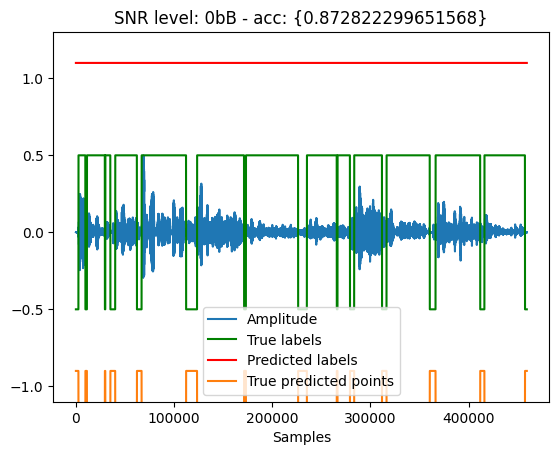

Time to execute model: 5.24139404296875


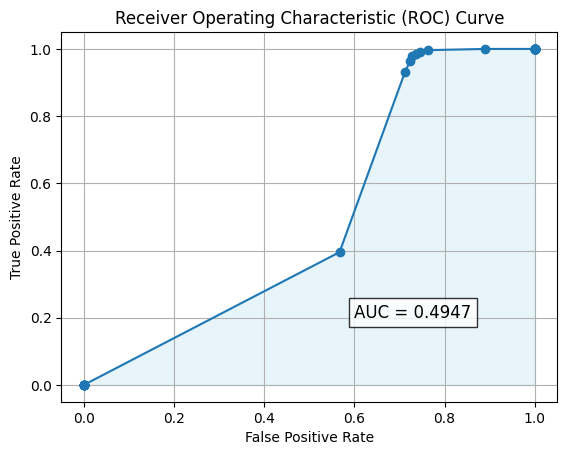

Accuracy : 0.815913688469319
Make plot


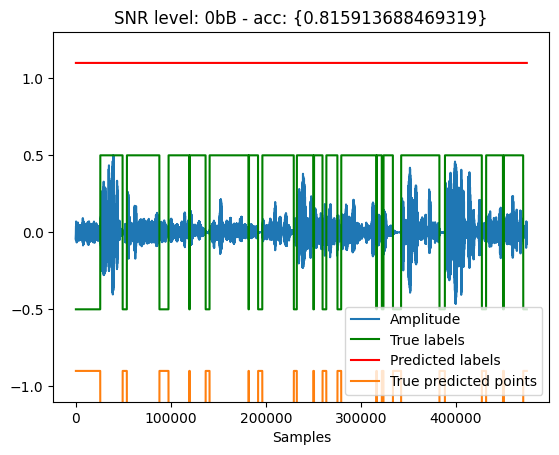

Time to execute model: 7.72404670715332


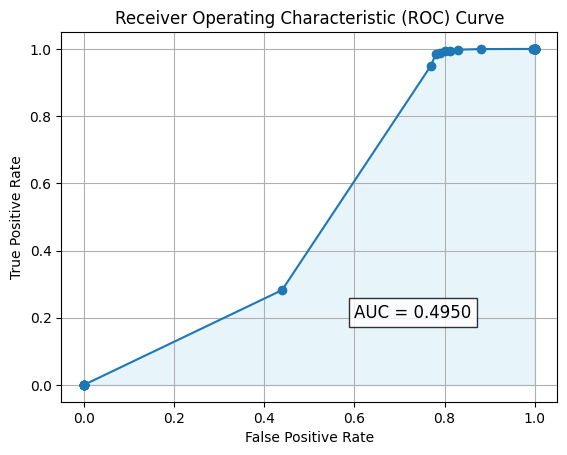

Accuracy : 0.8534047919293821
Make plot


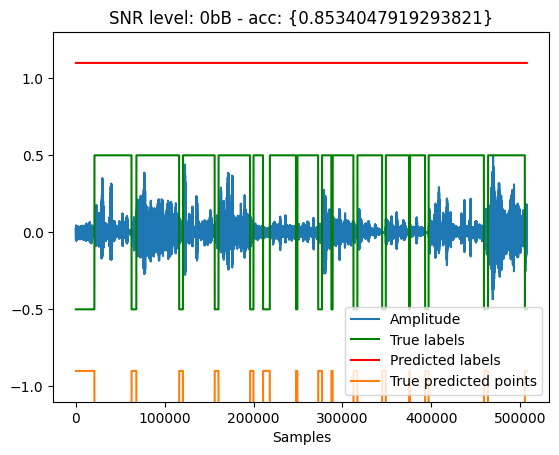

Time to execute model: 3.209352493286133


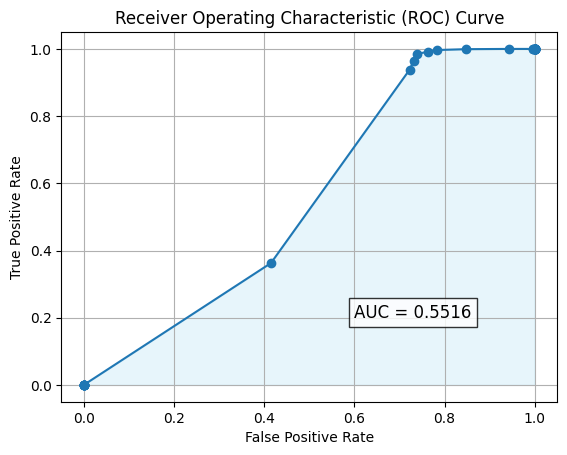

Epoch 2
--------------TRAIN-----------------
Current file/Number of files: [   30/ 4620]
loss VAD: 0.426432
Loss L: 0.009941134601831436
Accuracy of batch: 83.600679
Learning rate: 0.007000
Current file/Number of files: [   60/ 4620]
loss VAD: 0.495408
Loss L: 0.009664126671850681
Accuracy of batch: 79.632856
Learning rate: 0.007000
Current file/Number of files: [   90/ 4620]
loss VAD: 0.451527
Loss L: 0.009730255231261253
Accuracy of batch: 82.425474
Learning rate: 0.007000
Current file/Number of files: [  120/ 4620]
loss VAD: 0.427349
Loss L: 0.009822024032473564
Accuracy of batch: 83.943169
Learning rate: 0.007000
Current file/Number of files: [  150/ 4620]
loss VAD: 0.407020
Loss L: 0.009704876691102982
Accuracy of batch: 85.058597
Learning rate: 0.007000
Current file/Number of files: [  180/ 4620]
loss VAD: 0.479018
Loss L: 0.009666967205703259
Accuracy of batch: 80.620820
Learning rate: 0.007000
Current file/Number of files: [  210/ 4620]
loss VAD: 0.458866
Loss L: 0.009603593498

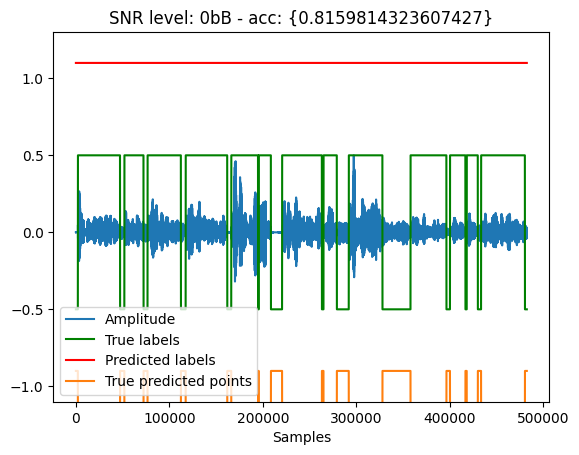

Time to execute model: 1.8329620361328125


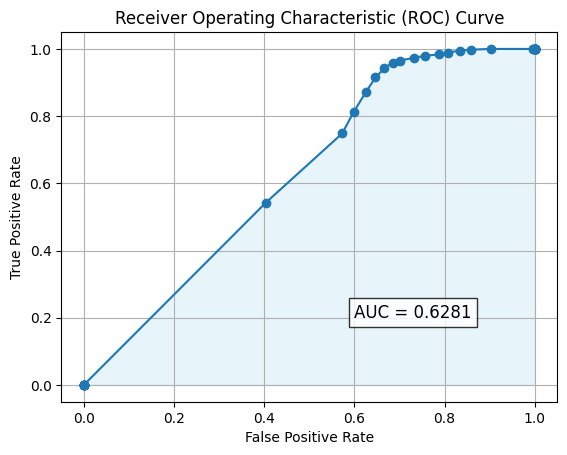

Accuracy : 0.8366305041480536
Make plot


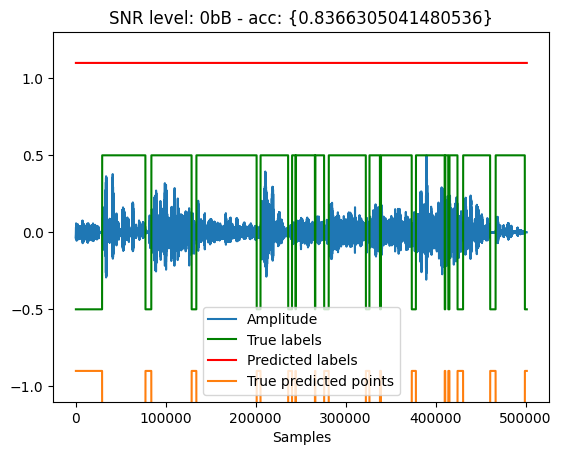

Time to execute model: 2.0966529846191406


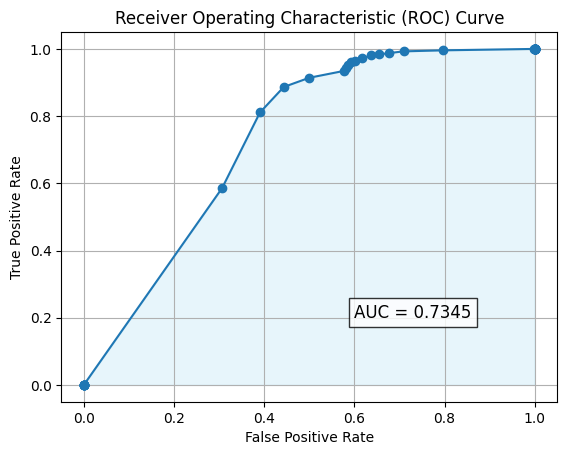

Accuracy : 0.8374105011933174
Make plot


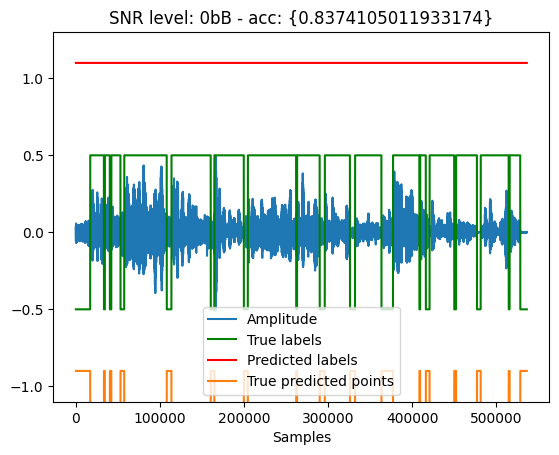

Time to execute model: 2.4271011352539062


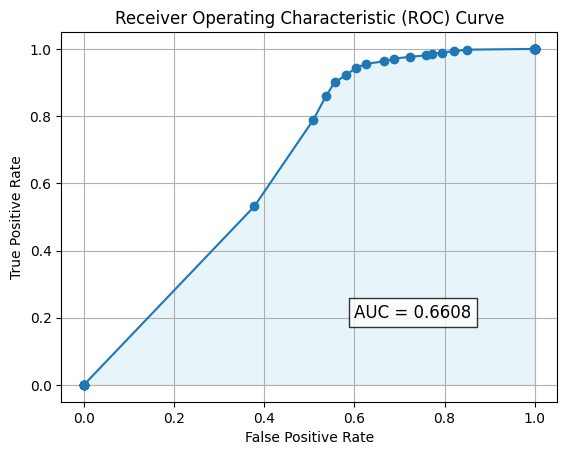

Epoch 3
--------------TRAIN-----------------
Current file/Number of files: [   30/ 4620]
loss VAD: 0.440439
Loss L: 0.015489074401557446
Accuracy of batch: 80.876910
Learning rate: 0.004900
Current file/Number of files: [   60/ 4620]
loss VAD: 0.371172
Loss L: 0.015398059040307999
Accuracy of batch: 84.044846
Learning rate: 0.004900
Current file/Number of files: [   90/ 4620]
loss VAD: 0.392763
Loss L: 0.015486306510865688
Accuracy of batch: 83.258457
Learning rate: 0.004900
Current file/Number of files: [  120/ 4620]
loss VAD: 0.498358
Loss L: 0.015507048927247524
Accuracy of batch: 77.543984
Learning rate: 0.004900
Current file/Number of files: [  150/ 4620]
loss VAD: 0.370369
Loss L: 0.015374377369880676
Accuracy of batch: 84.577401
Learning rate: 0.004900
Current file/Number of files: [  180/ 4620]
loss VAD: 0.458541
Loss L: 0.015355871059000492
Accuracy of batch: 79.108118
Learning rate: 0.004900
Current file/Number of files: [  210/ 4620]
loss VAD: 0.409869
Loss L: 0.015269347466

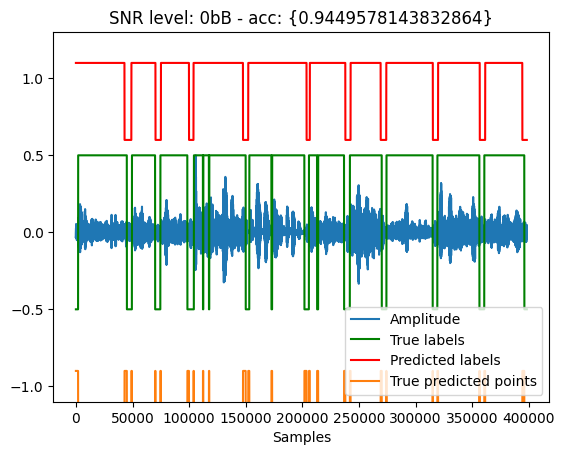

Time to execute model: 6.127595901489258


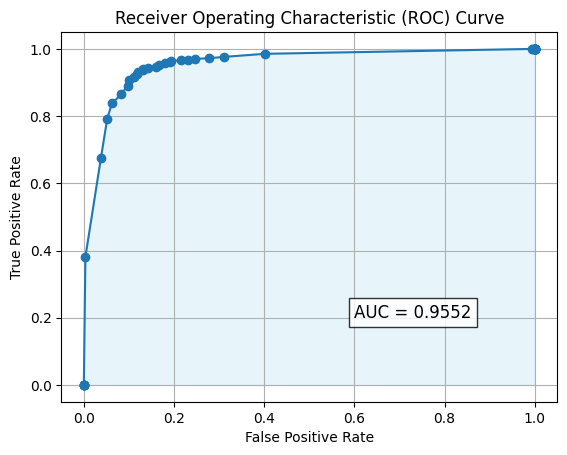

Accuracy : 0.8441890166028096
Make plot


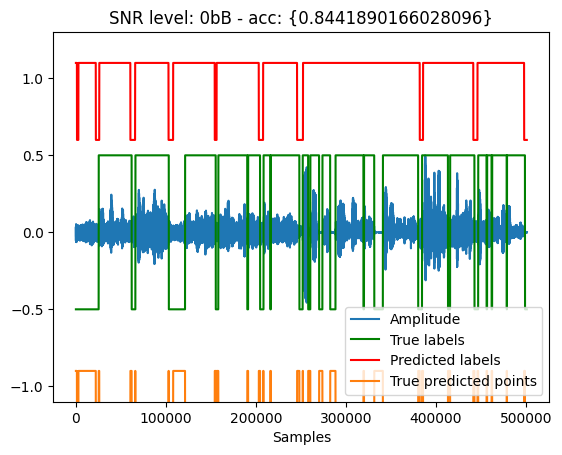

Time to execute model: 3.4596920013427734


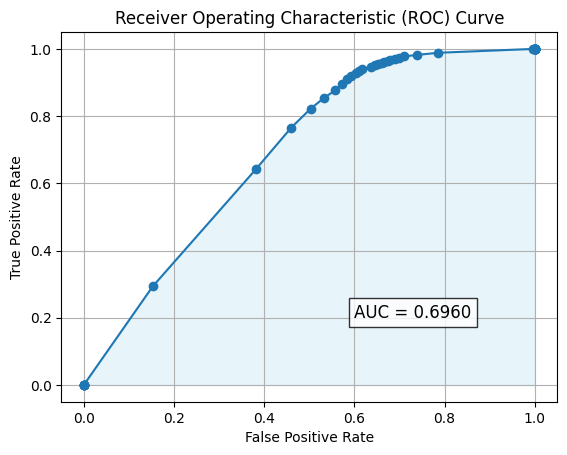

Accuracy : 0.883128558585556
Make plot


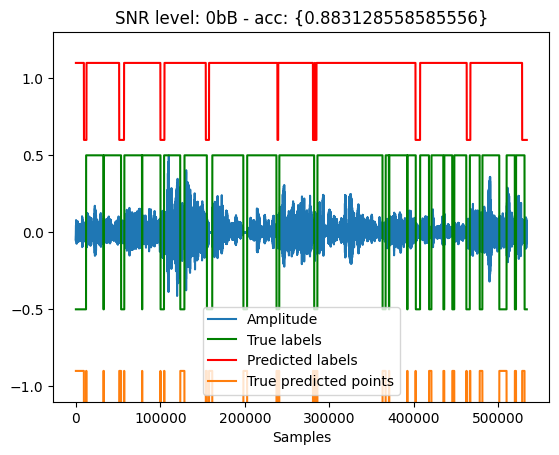

Time to execute model: 1.9893646240234375


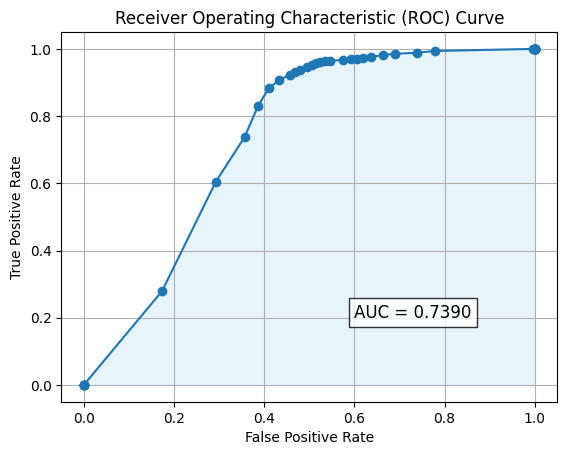

Epoch 4
--------------TRAIN-----------------
Current file/Number of files: [   30/ 4620]
loss VAD: 0.347538
Loss L: 0.017861157655715942
Accuracy of batch: 88.815378
Learning rate: 0.003430
Current file/Number of files: [   60/ 4620]
loss VAD: 0.365712
Loss L: 0.017848152667284012
Accuracy of batch: 87.352835
Learning rate: 0.003430
Current file/Number of files: [   90/ 4620]
loss VAD: 0.355645
Loss L: 0.017844488844275475
Accuracy of batch: 87.544654
Learning rate: 0.003430
Current file/Number of files: [  120/ 4620]
loss VAD: 0.387742
Loss L: 0.017838863655924797
Accuracy of batch: 86.269632
Learning rate: 0.003430
Current file/Number of files: [  150/ 4620]
loss VAD: 0.332592
Loss L: 0.017805056646466255
Accuracy of batch: 89.102219
Learning rate: 0.003430
Current file/Number of files: [  180/ 4620]
loss VAD: 0.409063
Loss L: 0.01781488209962845
Accuracy of batch: 85.719817
Learning rate: 0.003430
Current file/Number of files: [  210/ 4620]
loss VAD: 0.402726
Loss L: 0.0178026817739

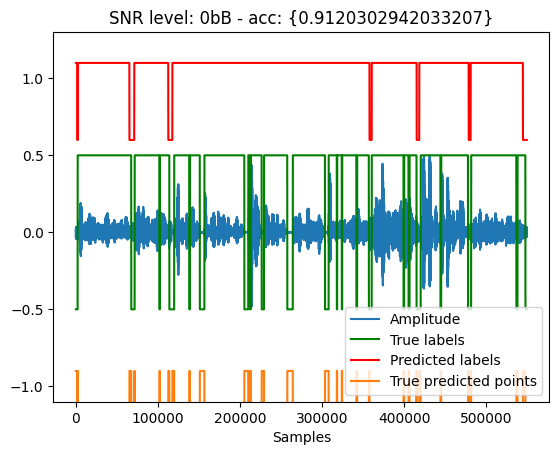

Time to execute model: 2.3050308227539062


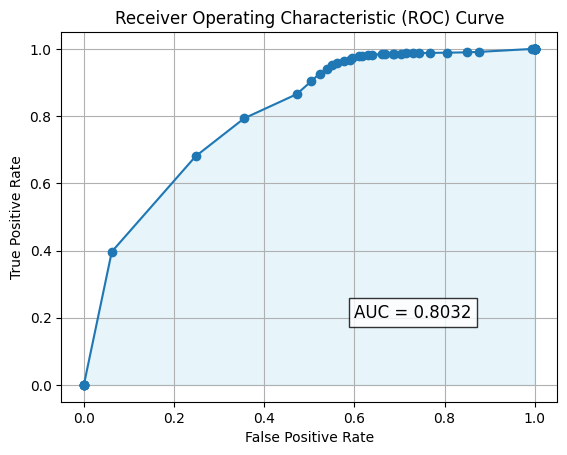

Accuracy : 0.885286783042394
Make plot


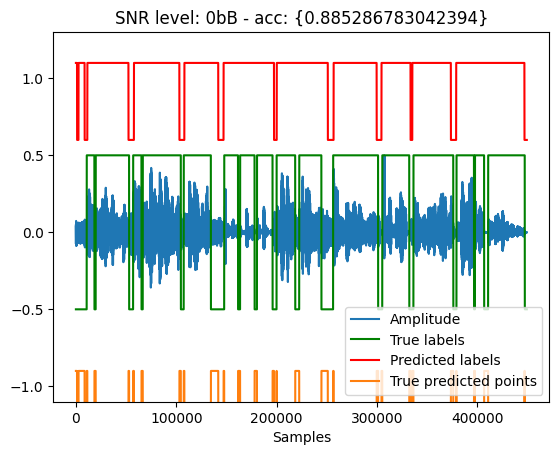

Time to execute model: 3.061532974243164


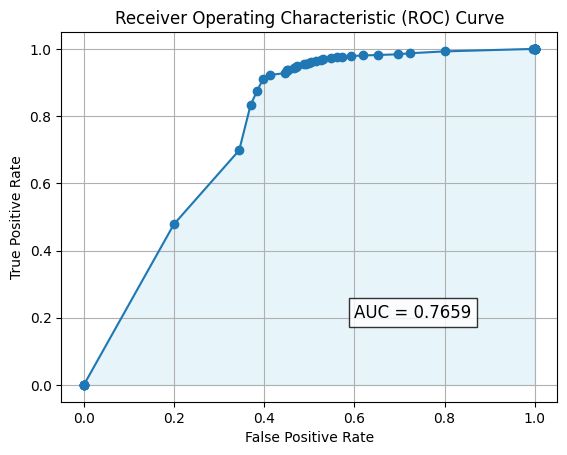

Accuracy : 0.907465495608532
Make plot


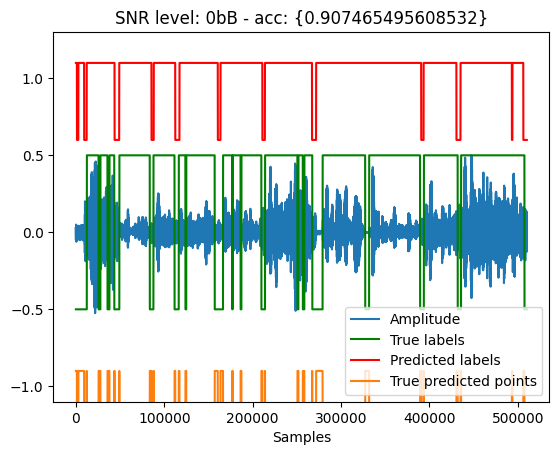

Time to execute model: 2.478361129760742


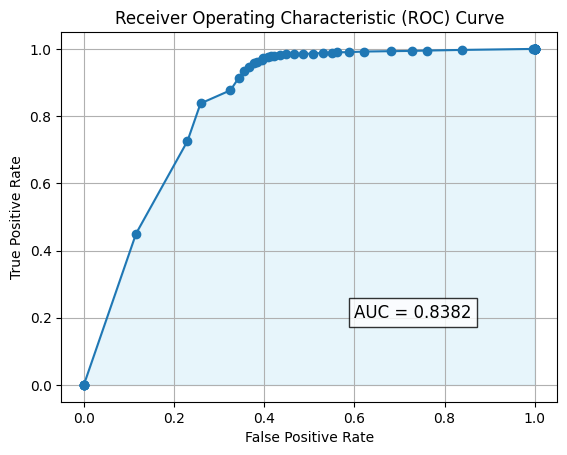

Epoch 5
--------------TRAIN-----------------
Current file/Number of files: [   30/ 4620]
loss VAD: 0.300236
Loss L: 0.018030306324362755
Accuracy of batch: 90.108644
Learning rate: 0.002401
Current file/Number of files: [   60/ 4620]
loss VAD: 0.339351
Loss L: 0.018009474501013756
Accuracy of batch: 88.350597
Learning rate: 0.002401
Current file/Number of files: [   90/ 4620]
loss VAD: 0.395467
Loss L: 0.018000472337007523
Accuracy of batch: 86.143910
Learning rate: 0.002401
Current file/Number of files: [  120/ 4620]
loss VAD: 0.427572
Loss L: 0.017988400533795357
Accuracy of batch: 84.624066
Learning rate: 0.002401
Current file/Number of files: [  150/ 4620]
loss VAD: 0.343909
Loss L: 0.017970582470297813
Accuracy of batch: 88.884856
Learning rate: 0.002401
Current file/Number of files: [  180/ 4620]
loss VAD: 0.358968
Loss L: 0.017980724573135376
Accuracy of batch: 88.022539
Learning rate: 0.002401
Current file/Number of files: [  210/ 4620]
loss VAD: 0.353225
Loss L: 0.017975078895

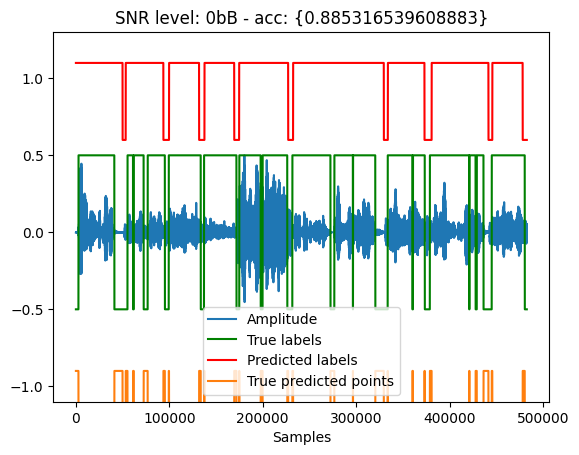

Time to execute model: 2.7663707733154297


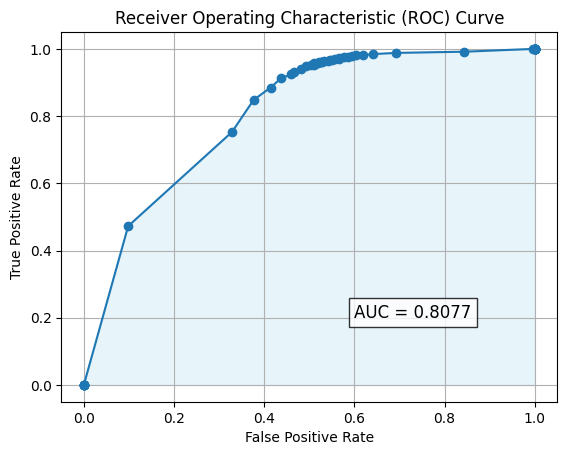

Accuracy : 0.8617136659436009
Make plot


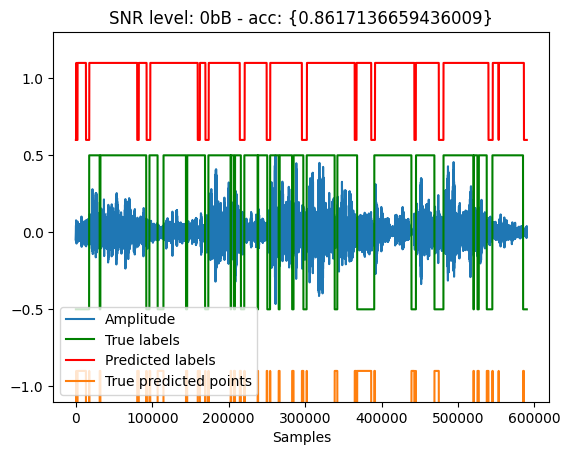

Time to execute model: 2.381563186645508


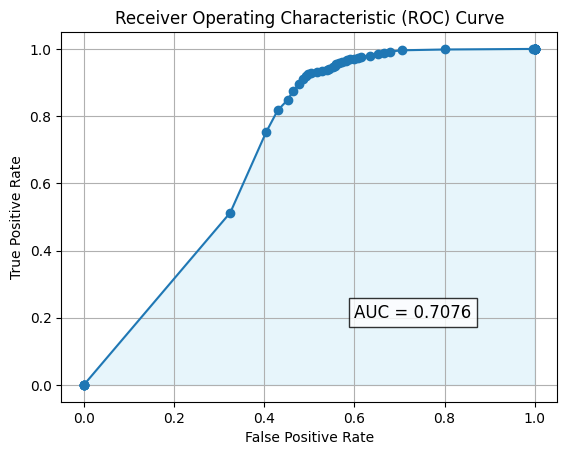

Accuracy : 0.8339089481946624
Make plot


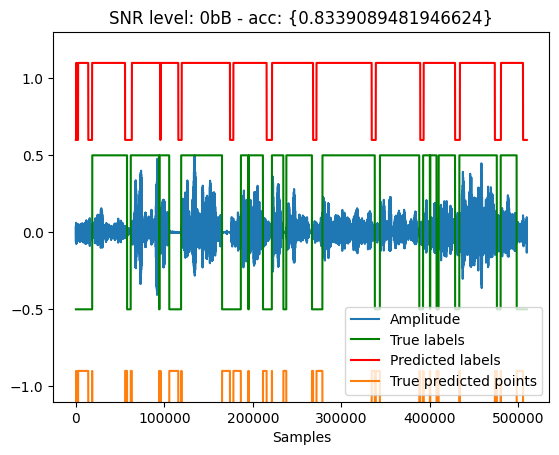

Time to execute model: 2.2950172424316406


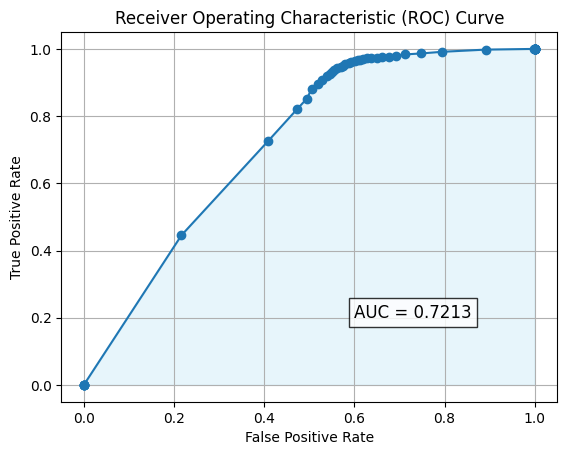

Epoch 6
--------------TRAIN-----------------
Current file/Number of files: [   30/ 4620]
loss VAD: 0.340389
Loss L: 0.018017174676060677
Accuracy of batch: 89.187852
Learning rate: 0.001681
Current file/Number of files: [   60/ 4620]
loss VAD: 0.358264
Loss L: 0.0180153027176857
Accuracy of batch: 88.056316
Learning rate: 0.001681
Current file/Number of files: [   90/ 4620]
loss VAD: 0.414184
Loss L: 0.018013492226600647
Accuracy of batch: 85.376814
Learning rate: 0.001681
Current file/Number of files: [  120/ 4620]
loss VAD: 0.351820
Loss L: 0.018020952120423317
Accuracy of batch: 87.652997
Learning rate: 0.001681
Current file/Number of files: [  150/ 4620]
loss VAD: 0.358698
Loss L: 0.01800956204533577
Accuracy of batch: 88.155110
Learning rate: 0.001681
Current file/Number of files: [  180/ 4620]
loss VAD: 0.338087
Loss L: 0.01800878532230854
Accuracy of batch: 88.833354
Learning rate: 0.001681
Current file/Number of files: [  210/ 4620]
loss VAD: 0.388751
Loss L: 0.0180032458156347

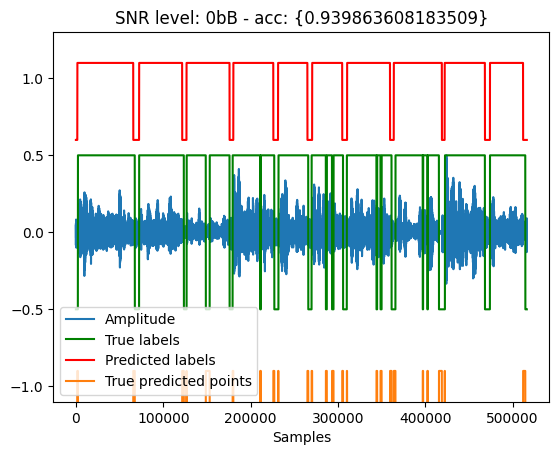

Time to execute model: 2.277851104736328


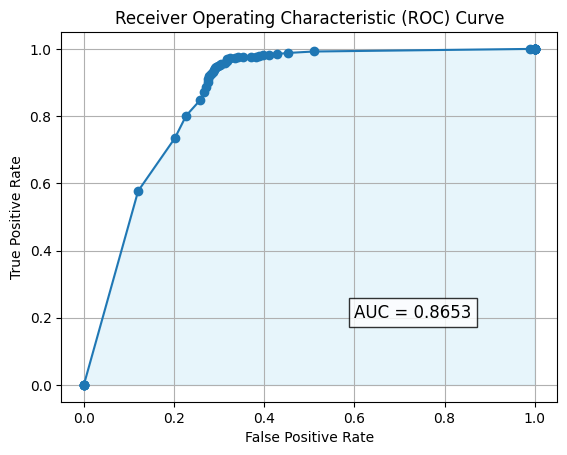

Accuracy : 0.8759524535202682
Make plot


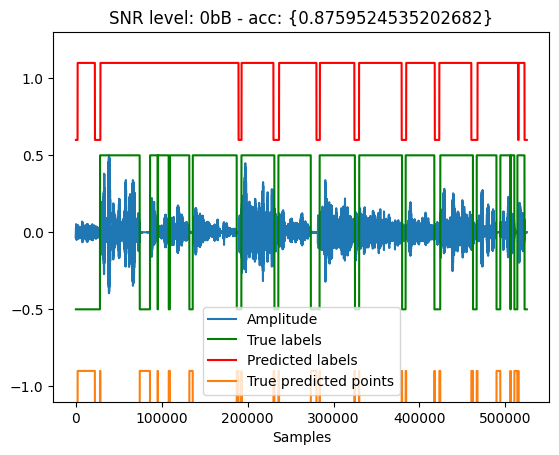

Time to execute model: 2.5370121002197266


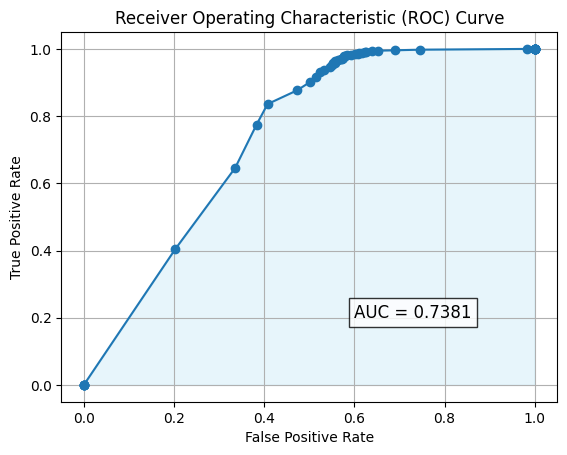

Accuracy : 0.9014290949065592
Make plot


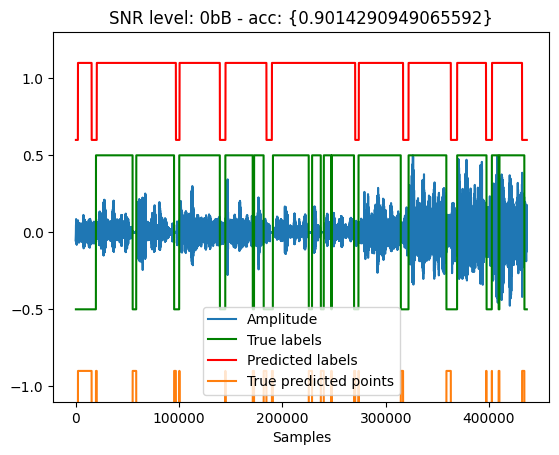

Time to execute model: 8.537530899047852


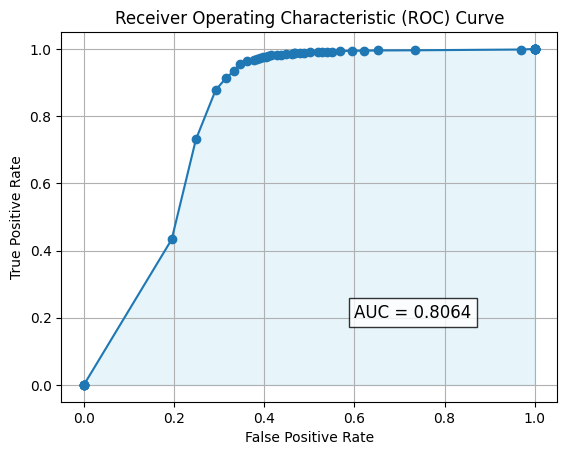

Epoch 7
--------------TRAIN-----------------
Current file/Number of files: [   30/ 4620]
loss VAD: 0.303900
Loss L: 0.01834244653582573
Accuracy of batch: 90.226033
Learning rate: 0.001176
Current file/Number of files: [   60/ 4620]
loss VAD: 0.374126
Loss L: 0.01834459789097309
Accuracy of batch: 87.479234
Learning rate: 0.001176
Current file/Number of files: [   90/ 4620]
loss VAD: 0.403503
Loss L: 0.018341293558478355
Accuracy of batch: 86.019149
Learning rate: 0.001176
Current file/Number of files: [  120/ 4620]
loss VAD: 0.395343
Loss L: 0.01833188347518444
Accuracy of batch: 86.092213
Learning rate: 0.001176
Current file/Number of files: [  150/ 4620]
loss VAD: 0.315083
Loss L: 0.018322885036468506
Accuracy of batch: 90.216083
Learning rate: 0.001176
Current file/Number of files: [  180/ 4620]
loss VAD: 0.365595
Loss L: 0.01832946389913559
Accuracy of batch: 87.446914
Learning rate: 0.001176
Current file/Number of files: [  210/ 4620]
loss VAD: 0.338740
Loss L: 0.0183320641517639

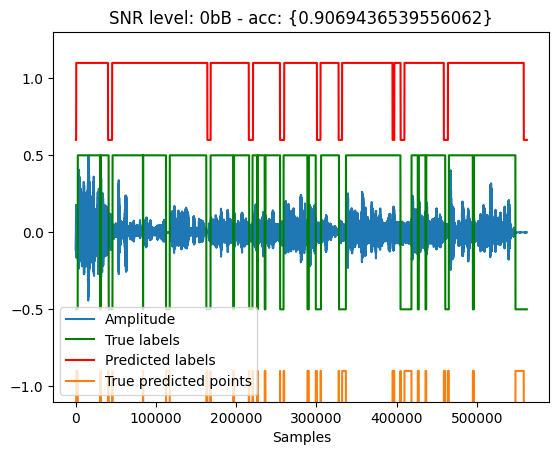

Time to execute model: 2.241849899291992


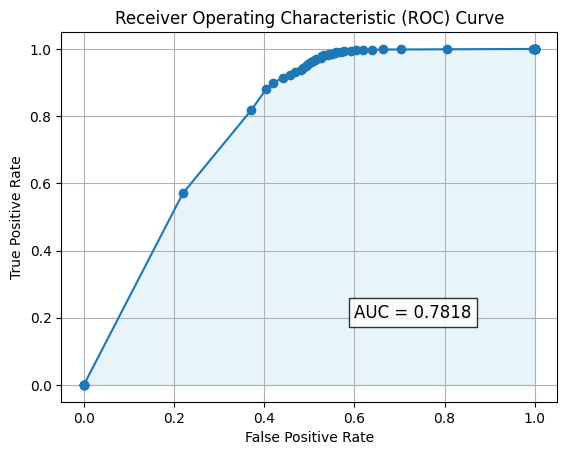

Accuracy : 0.8921319796954315
Make plot


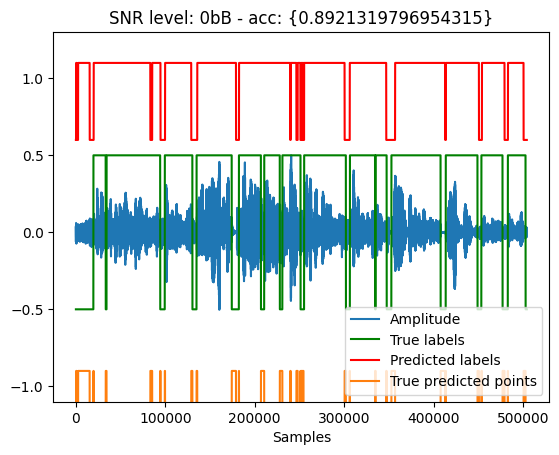

Time to execute model: 3.078460693359375


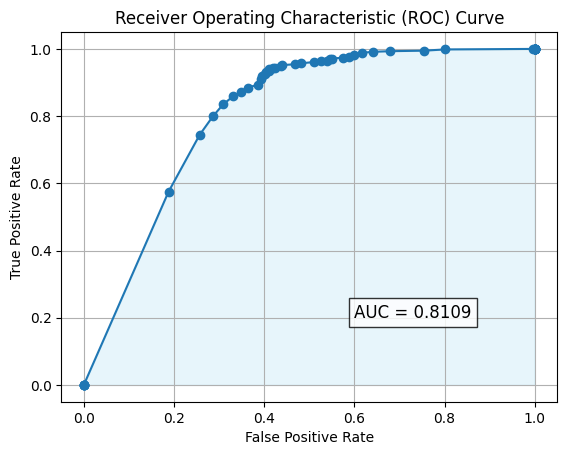

Accuracy : 0.8901315789473684
Make plot


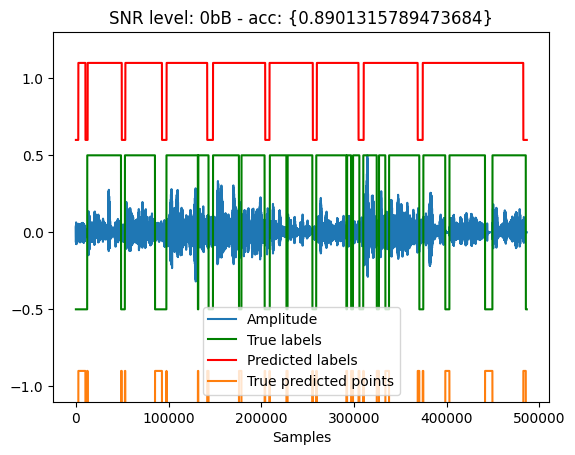

Time to execute model: 3.1523704528808594


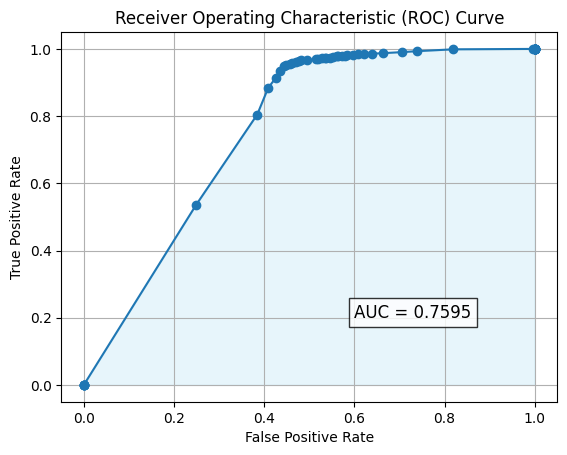

Epoch 8
--------------TRAIN-----------------
Current file/Number of files: [   30/ 4620]
loss VAD: 0.304642
Loss L: 0.01783534325659275
Accuracy of batch: 90.456232
Learning rate: 0.000824
Current file/Number of files: [   60/ 4620]
loss VAD: 0.355882
Loss L: 0.017833245918154716
Accuracy of batch: 88.322096
Learning rate: 0.000824
Current file/Number of files: [   90/ 4620]
loss VAD: 0.353683
Loss L: 0.017832184210419655
Accuracy of batch: 88.085980
Learning rate: 0.000824
Current file/Number of files: [  120/ 4620]
loss VAD: 0.378264
Loss L: 0.01782454364001751
Accuracy of batch: 86.529733
Learning rate: 0.000824
Current file/Number of files: [  150/ 4620]
loss VAD: 0.291493
Loss L: 0.017821161076426506
Accuracy of batch: 90.468882
Learning rate: 0.000824
Current file/Number of files: [  180/ 4620]
loss VAD: 0.275757
Loss L: 0.017813829705119133
Accuracy of batch: 91.425891
Learning rate: 0.000824
Current file/Number of files: [  210/ 4620]
loss VAD: 0.308365
Loss L: 0.01781791448593

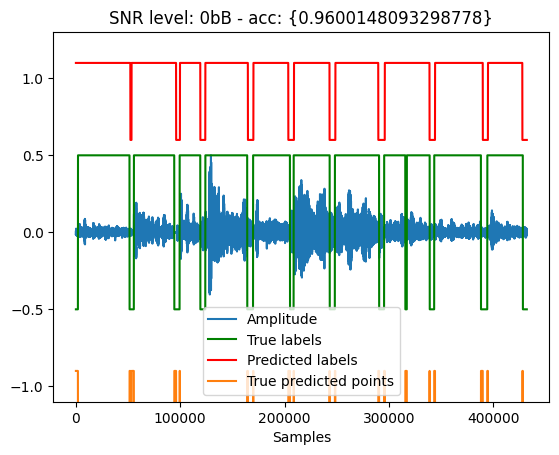

Time to execute model: 2.8634071350097656


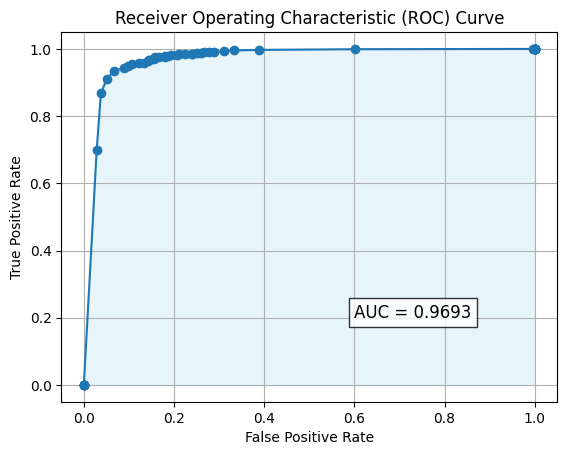

Accuracy : 0.9171528588098017
Make plot


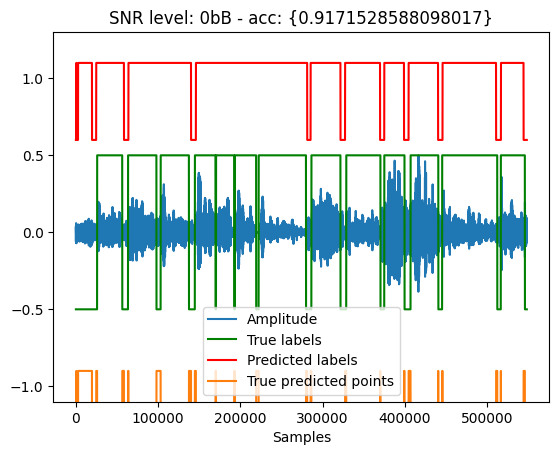

Time to execute model: 2.3958683013916016


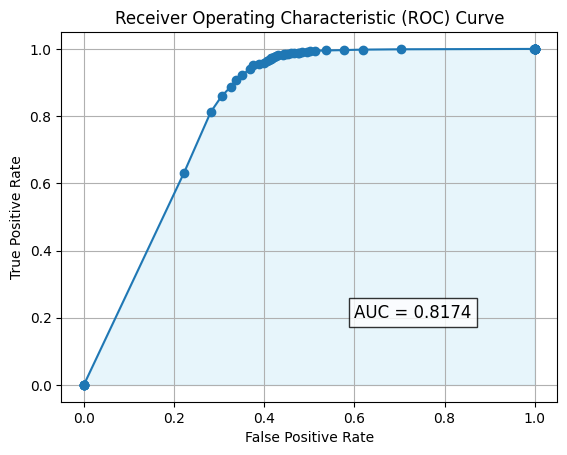

Accuracy : 0.8955089820359281
Make plot


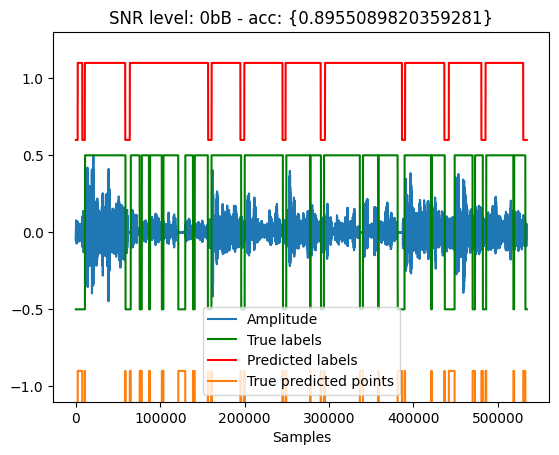

Time to execute model: 5.041837692260742


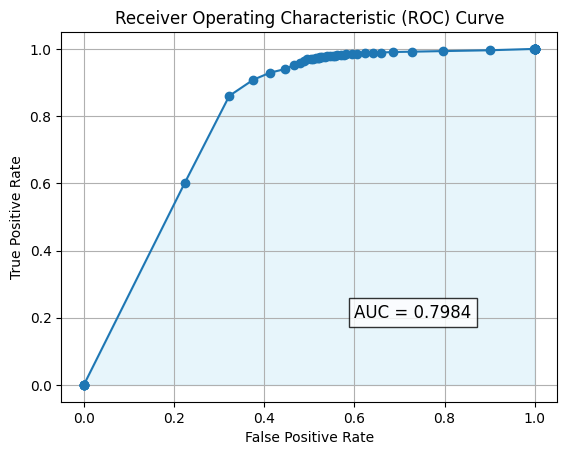

Epoch 9
--------------TRAIN-----------------
Current file/Number of files: [   30/ 4620]
loss VAD: 0.377572
Loss L: 0.017596466466784477
Accuracy of batch: 87.077783
Learning rate: 0.000576
Current file/Number of files: [   60/ 4620]
loss VAD: 0.310270
Loss L: 0.01759122870862484
Accuracy of batch: 89.841663
Learning rate: 0.000576
Current file/Number of files: [   90/ 4620]
loss VAD: 0.328262
Loss L: 0.017591973766684532
Accuracy of batch: 89.325074
Learning rate: 0.000576
Current file/Number of files: [  120/ 4620]
loss VAD: 0.334123
Loss L: 0.017589140683412552
Accuracy of batch: 88.895566
Learning rate: 0.000576
Current file/Number of files: [  150/ 4620]
loss VAD: 0.356463
Loss L: 0.01759045012295246
Accuracy of batch: 88.011096
Learning rate: 0.000576
Current file/Number of files: [  180/ 4620]
loss VAD: 0.320832
Loss L: 0.017587274312973022
Accuracy of batch: 89.281152
Learning rate: 0.000576
Current file/Number of files: [  210/ 4620]
loss VAD: 0.349039
Loss L: 0.01758416928350

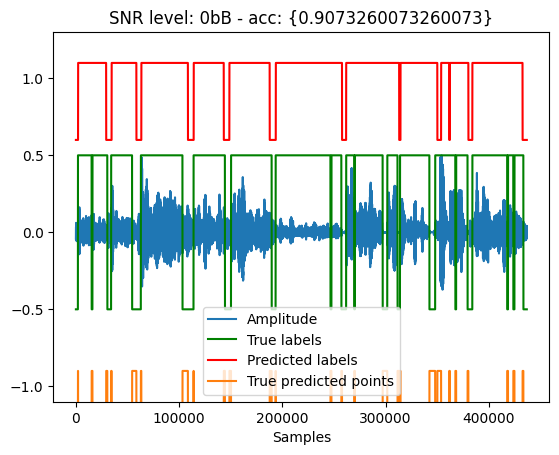

Time to execute model: 2.480745315551758


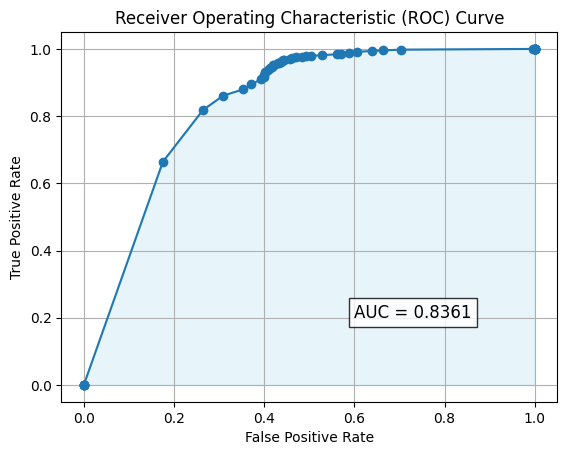

Accuracy : 0.7877877877877878
Make plot


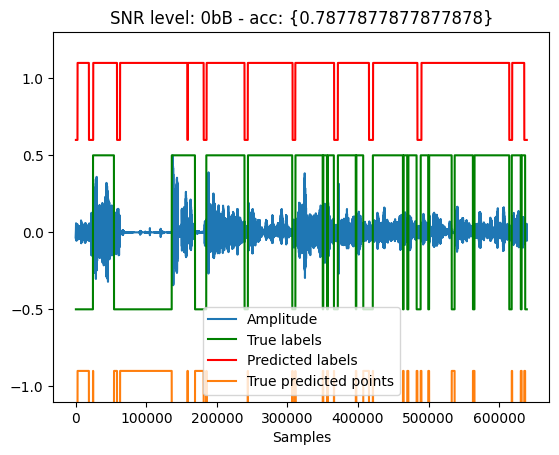

Time to execute model: 5.110502243041992


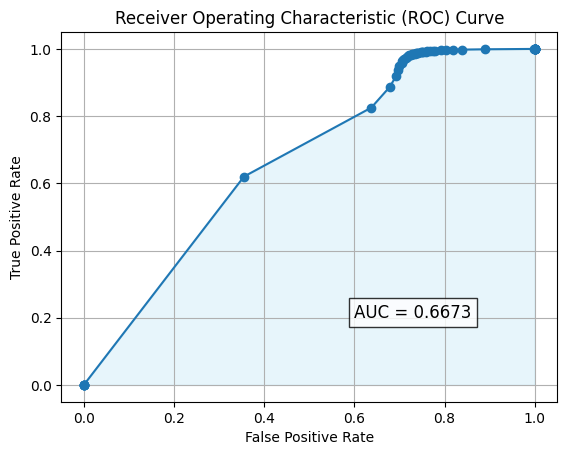

Accuracy : 0.8491537895511405
Make plot


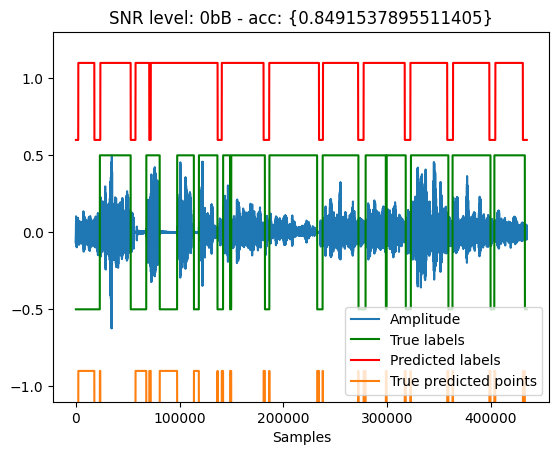

Time to execute model: 3.0977725982666016


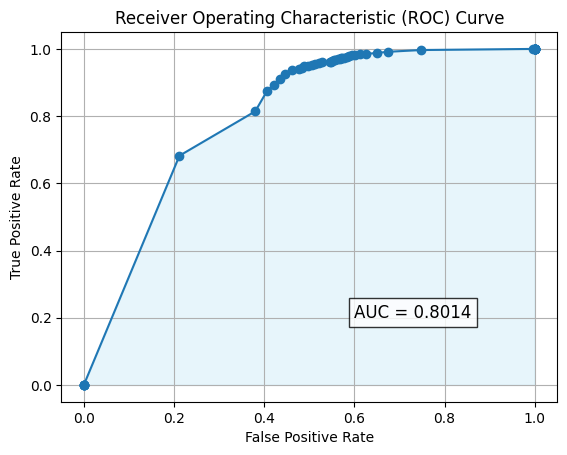

Epoch 10
--------------TRAIN-----------------
Current file/Number of files: [   30/ 4620]
loss VAD: 0.307668
Loss L: 0.017333967611193657
Accuracy of batch: 90.185779
Learning rate: 0.000404
Current file/Number of files: [   60/ 4620]
loss VAD: 0.310433
Loss L: 0.017333462834358215
Accuracy of batch: 90.515055
Learning rate: 0.000404
Current file/Number of files: [   90/ 4620]
loss VAD: 0.386998
Loss L: 0.01733551360666752
Accuracy of batch: 86.607284
Learning rate: 0.000404
Current file/Number of files: [  120/ 4620]
loss VAD: 0.335324
Loss L: 0.01733377017080784
Accuracy of batch: 88.807675
Learning rate: 0.000404
Current file/Number of files: [  150/ 4620]
loss VAD: 0.387513
Loss L: 0.017330212518572807
Accuracy of batch: 86.234675
Learning rate: 0.000404
Current file/Number of files: [  180/ 4620]
loss VAD: 0.330428
Loss L: 0.017324961721897125
Accuracy of batch: 89.370107
Learning rate: 0.000404
Current file/Number of files: [  210/ 4620]
loss VAD: 0.353870
Loss L: 0.0173220150172

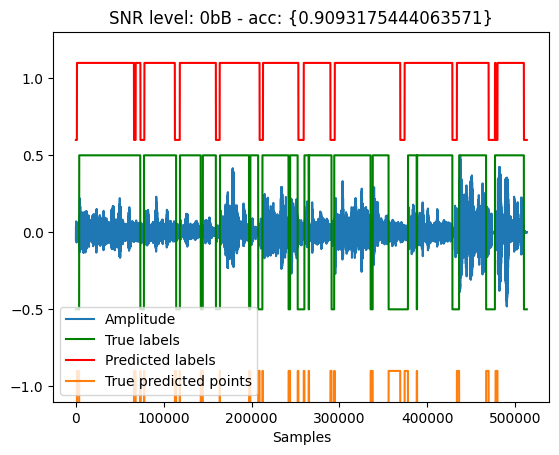

Time to execute model: 2.0706653594970703


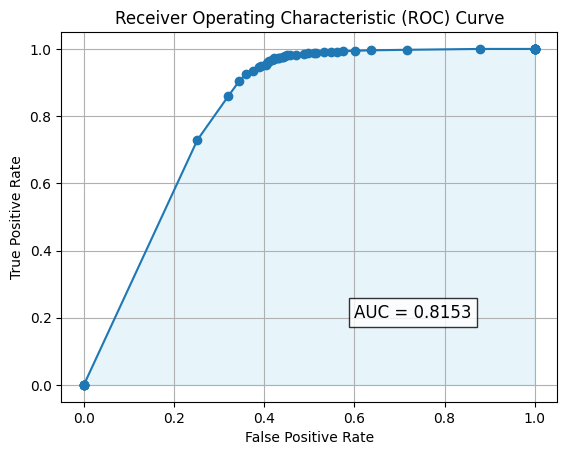

Accuracy : 0.9371108343711083
Make plot


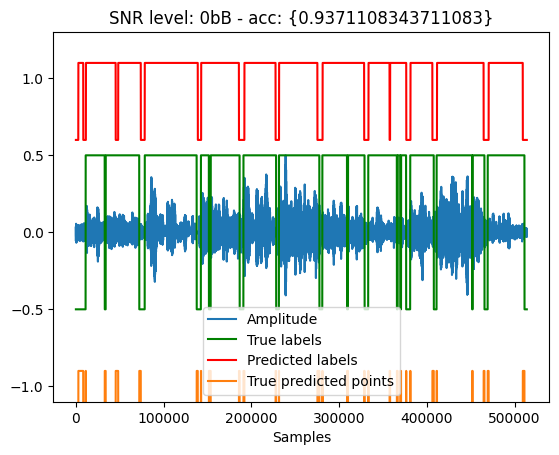

Time to execute model: 2.9904842376708984


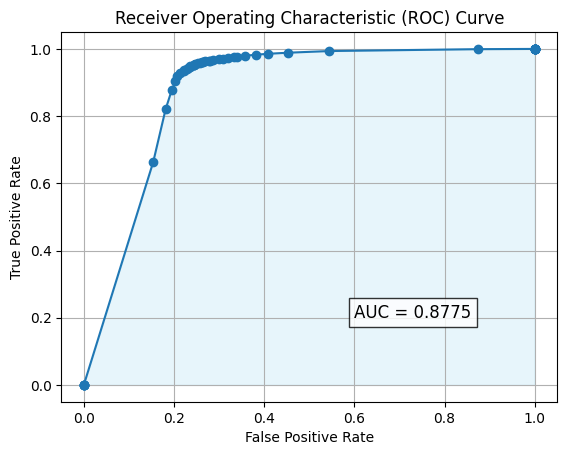

Accuracy : 0.9335180055401662
Make plot


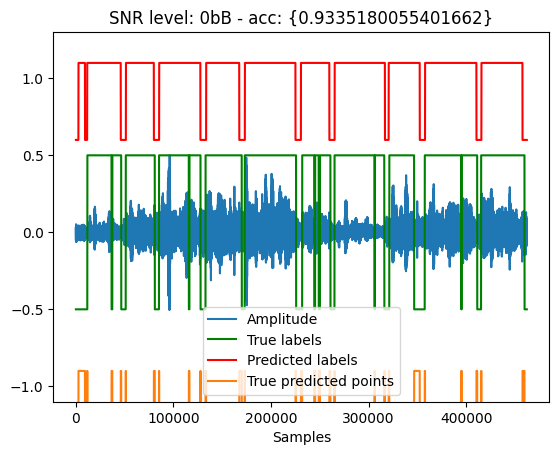

Time to execute model: 2.1202564239501953


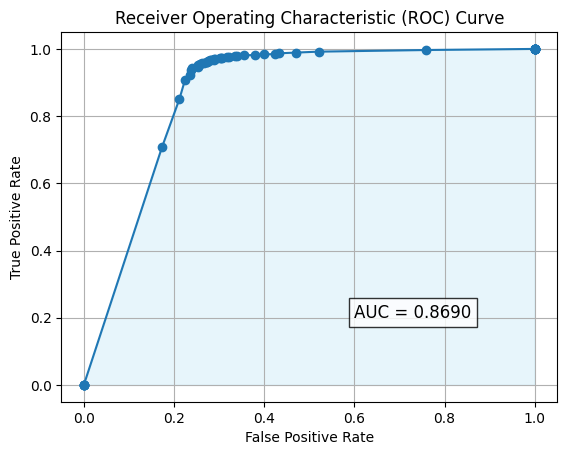

Epoch 11
--------------TRAIN-----------------
Current file/Number of files: [   30/ 4620]
loss VAD: 0.297254
Loss L: 0.017161807045340538
Accuracy of batch: 90.366820
Learning rate: 0.000282
Current file/Number of files: [   60/ 4620]
loss VAD: 0.317406
Loss L: 0.017161071300506592
Accuracy of batch: 89.958277
Learning rate: 0.000282
Current file/Number of files: [   90/ 4620]
loss VAD: 0.310385
Loss L: 0.017160333693027496
Accuracy of batch: 90.301205
Learning rate: 0.000282
Current file/Number of files: [  120/ 4620]
loss VAD: 0.390879
Loss L: 0.017159929499030113
Accuracy of batch: 86.049819
Learning rate: 0.000282
Current file/Number of files: [  150/ 4620]
loss VAD: 0.369658
Loss L: 0.01715521514415741
Accuracy of batch: 87.335550
Learning rate: 0.000282
Current file/Number of files: [  180/ 4620]
loss VAD: 0.313740
Loss L: 0.01715358905494213
Accuracy of batch: 89.846009
Learning rate: 0.000282
Current file/Number of files: [  210/ 4620]
loss VAD: 0.333461
Loss L: 0.0171530265361

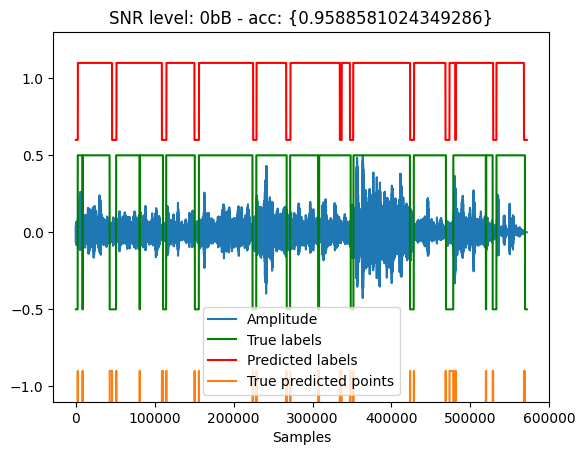

Time to execute model: 3.0870437622070312


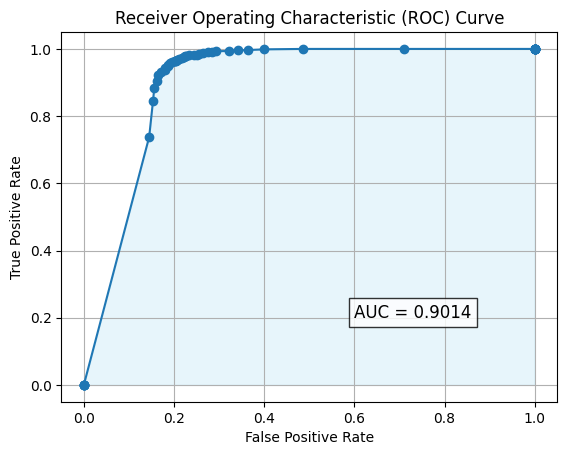

Accuracy : 0.8940201302545885
Make plot


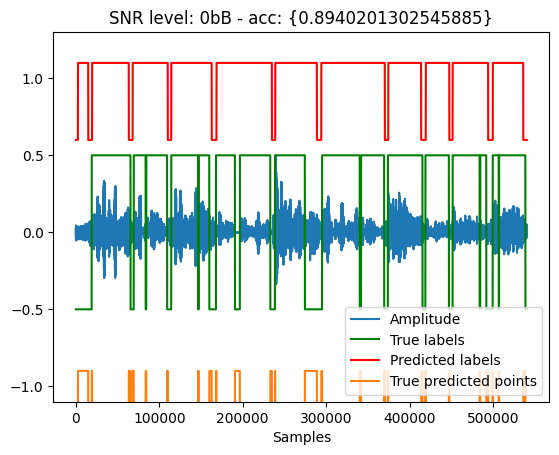

Time to execute model: 2.1300315856933594


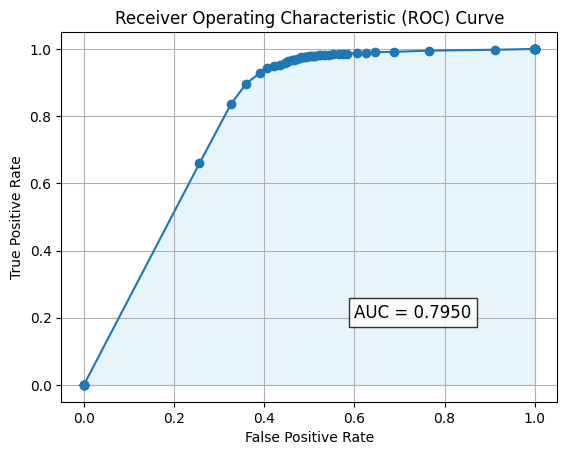

Accuracy : 0.8854612967723507
Make plot


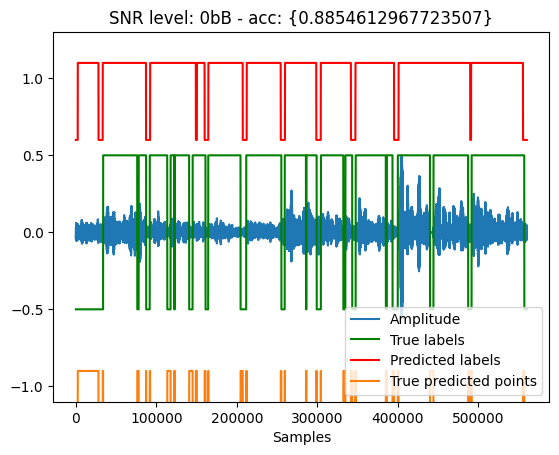

Time to execute model: 3.4558773040771484


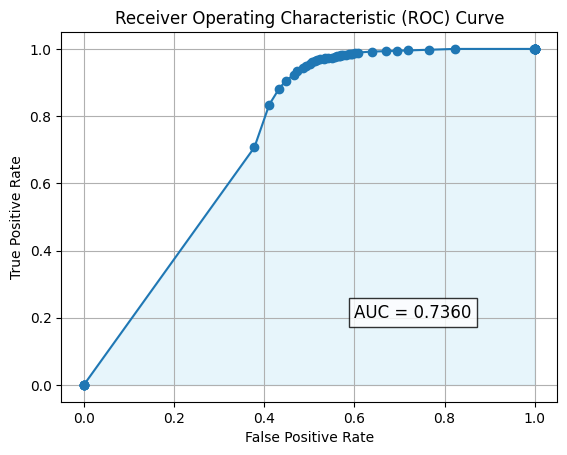

Epoch 12
--------------TRAIN-----------------
Current file/Number of files: [   30/ 4620]
loss VAD: 0.319024
Loss L: 0.017013292759656906
Accuracy of batch: 89.929309
Learning rate: 0.000198
Current file/Number of files: [   60/ 4620]
loss VAD: 0.376096
Loss L: 0.017012612894177437
Accuracy of batch: 87.002955
Learning rate: 0.000198
Current file/Number of files: [   90/ 4620]
loss VAD: 0.324674
Loss L: 0.01701022870838642
Accuracy of batch: 89.315894
Learning rate: 0.000198
Current file/Number of files: [  120/ 4620]
loss VAD: 0.370007
Loss L: 0.017009977251291275
Accuracy of batch: 87.494861
Learning rate: 0.000198
Current file/Number of files: [  150/ 4620]
loss VAD: 0.310732
Loss L: 0.017008762806653976
Accuracy of batch: 90.117424
Learning rate: 0.000198
Current file/Number of files: [  180/ 4620]
loss VAD: 0.362665
Loss L: 0.017009086906909943
Accuracy of batch: 87.687091
Learning rate: 0.000198
Current file/Number of files: [  210/ 4620]
loss VAD: 0.393792
Loss L: 0.017008336260

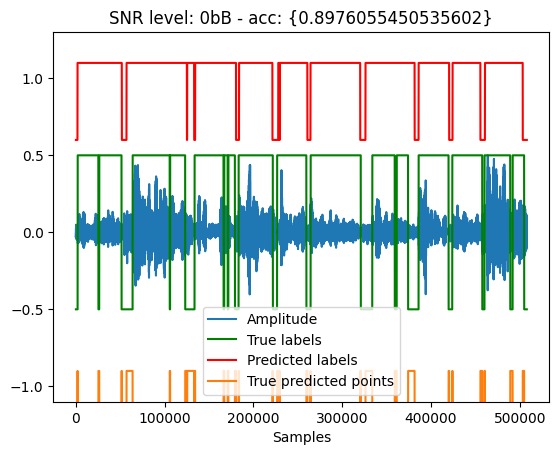

Time to execute model: 2.437591552734375


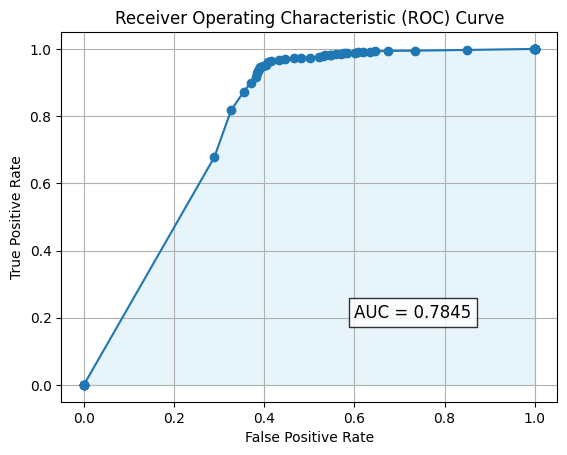

Accuracy : 0.8803442531926707
Make plot


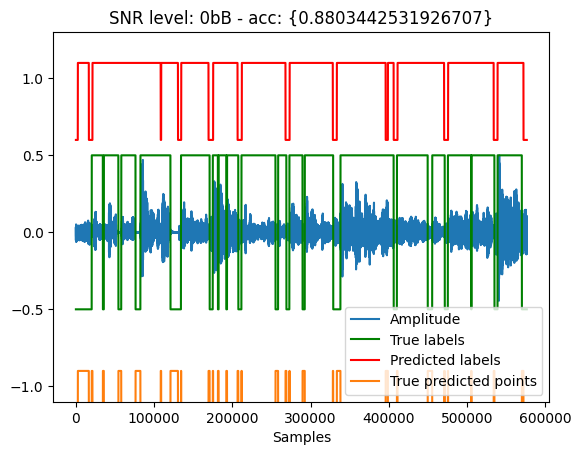

Time to execute model: 3.220081329345703


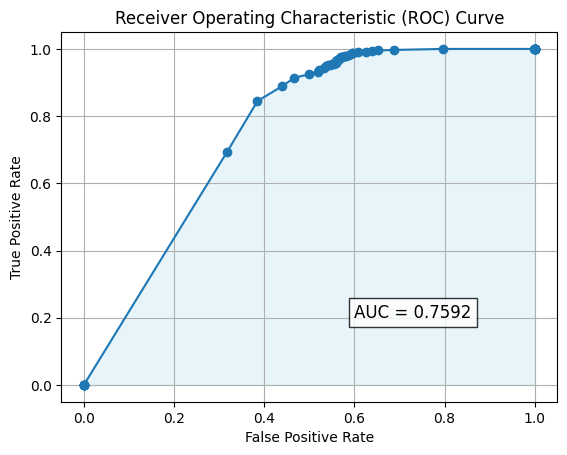

Accuracy : 0.8710359408033826
Make plot


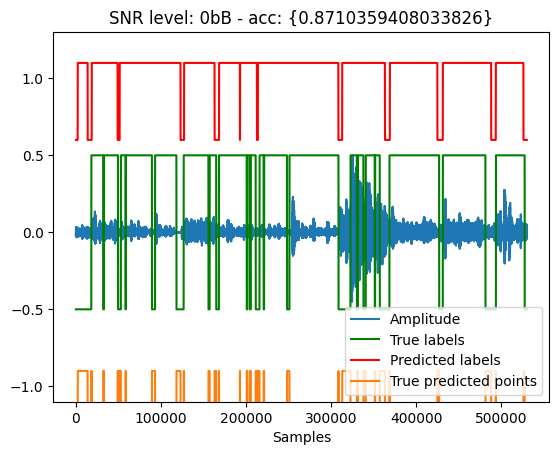

Time to execute model: 2.500295639038086


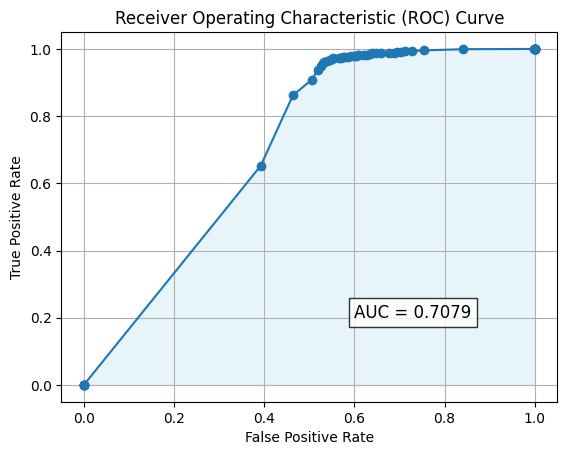

Epoch 13
--------------TRAIN-----------------
Current file/Number of files: [   30/ 4620]
loss VAD: 0.355883
Loss L: 0.016867149621248245
Accuracy of batch: 87.839379
Learning rate: 0.000138
Current file/Number of files: [   60/ 4620]
loss VAD: 0.341843
Loss L: 0.016865598037838936
Accuracy of batch: 88.722713
Learning rate: 0.000138
Current file/Number of files: [   90/ 4620]
loss VAD: 0.389116
Loss L: 0.016865290701389313
Accuracy of batch: 86.684370
Learning rate: 0.000138
Current file/Number of files: [  120/ 4620]
loss VAD: 0.358382
Loss L: 0.016865521669387817
Accuracy of batch: 87.873459
Learning rate: 0.000138
Current file/Number of files: [  150/ 4620]
loss VAD: 0.394106
Loss L: 0.016864202916622162
Accuracy of batch: 86.384419
Learning rate: 0.000138
Current file/Number of files: [  180/ 4620]
loss VAD: 0.309726
Loss L: 0.016863415017724037
Accuracy of batch: 89.843906
Learning rate: 0.000138
Current file/Number of files: [  210/ 4620]
loss VAD: 0.321322
Loss L: 0.01686336845

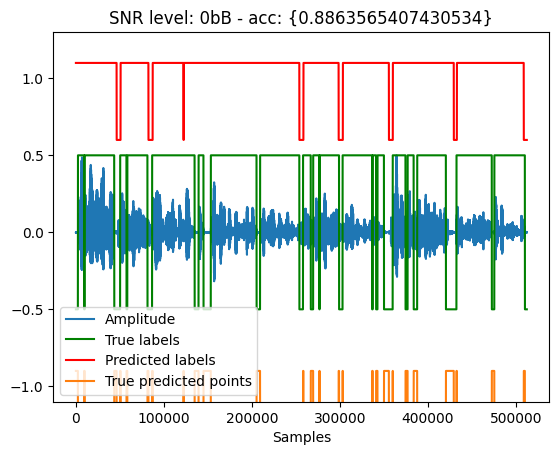

Time to execute model: 3.719329833984375


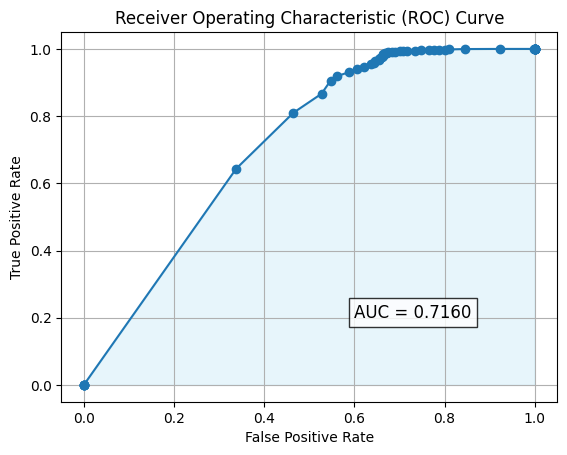

Accuracy : 0.929092500729501
Make plot


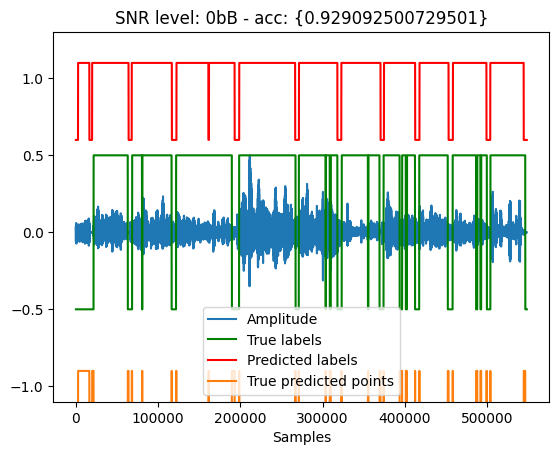

Time to execute model: 2.4547576904296875


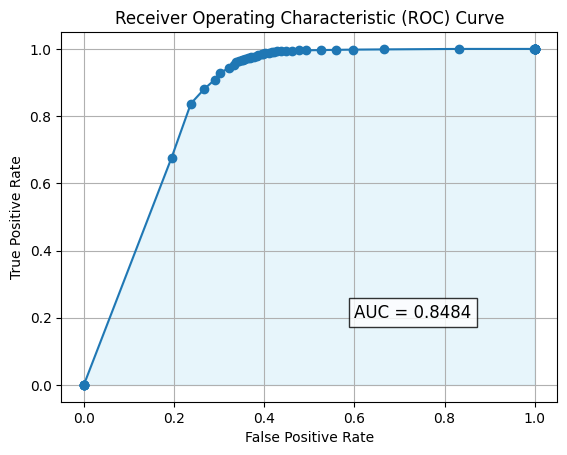

Accuracy : 0.8814790359854737
Make plot


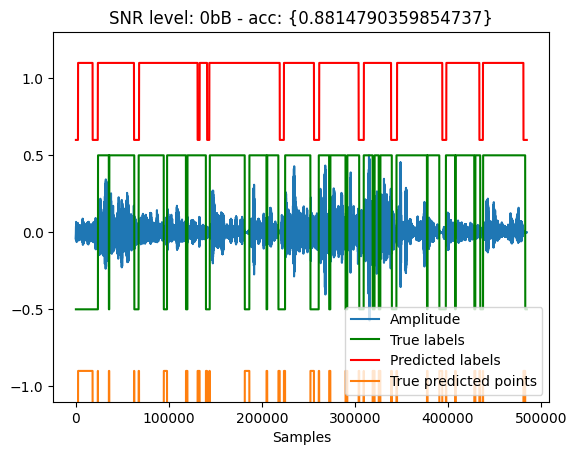

Time to execute model: 2.4268627166748047


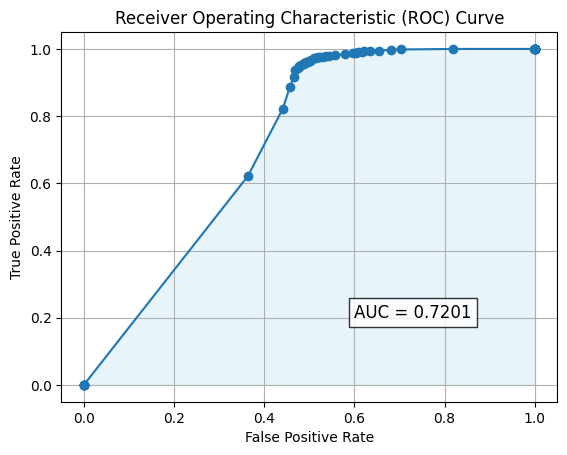

Epoch 14
--------------TRAIN-----------------
Current file/Number of files: [   30/ 4620]
loss VAD: 0.293777
Loss L: 0.016757266595959663
Accuracy of batch: 90.781340
Learning rate: 0.000097
Current file/Number of files: [   60/ 4620]
loss VAD: 0.381768
Loss L: 0.01675679162144661
Accuracy of batch: 87.190366
Learning rate: 0.000097
Current file/Number of files: [   90/ 4620]
loss VAD: 0.389934
Loss L: 0.016755469143390656
Accuracy of batch: 86.556295
Learning rate: 0.000097
Current file/Number of files: [  120/ 4620]
loss VAD: 0.307810
Loss L: 0.016754647716879845
Accuracy of batch: 90.374278
Learning rate: 0.000097
Current file/Number of files: [  150/ 4620]
loss VAD: 0.328387
Loss L: 0.01675472967326641
Accuracy of batch: 89.452709
Learning rate: 0.000097
Current file/Number of files: [  180/ 4620]
loss VAD: 0.363413
Loss L: 0.01675444282591343
Accuracy of batch: 87.831844
Learning rate: 0.000097
Current file/Number of files: [  210/ 4620]
loss VAD: 0.286293
Loss L: 0.01675351895391

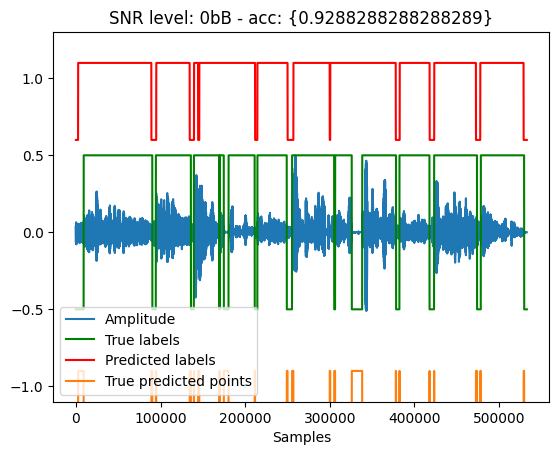

Time to execute model: 2.399921417236328


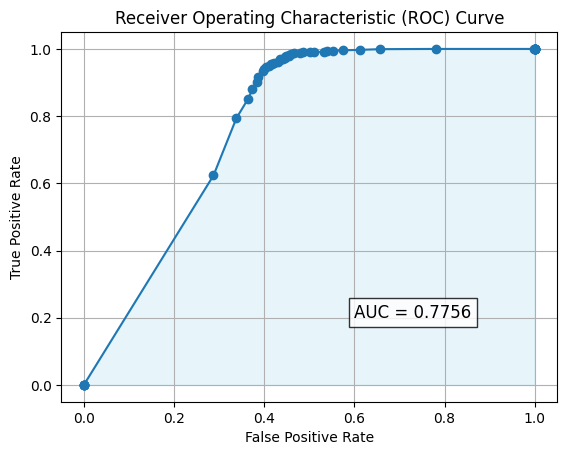

Accuracy : 0.8869488014205387
Make plot


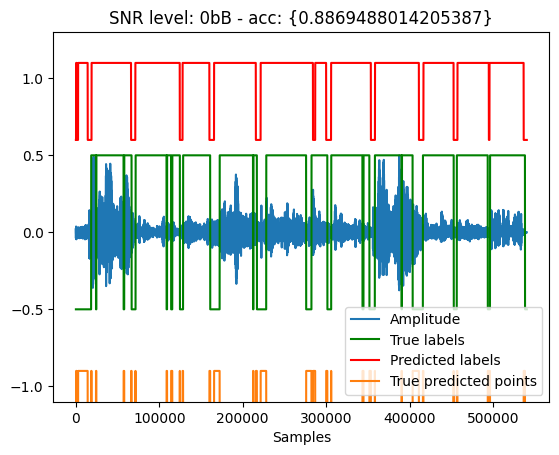

Time to execute model: 1.9817352294921875


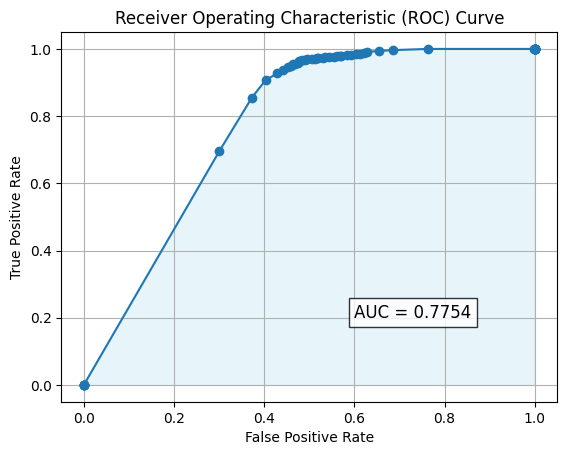

Accuracy : 0.883305785123967
Make plot


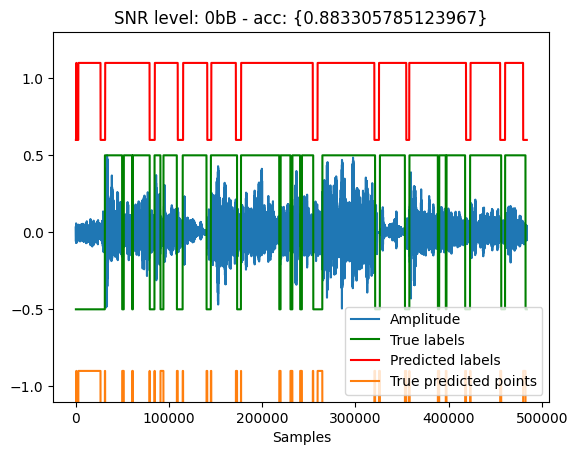

Time to execute model: 2.3505687713623047


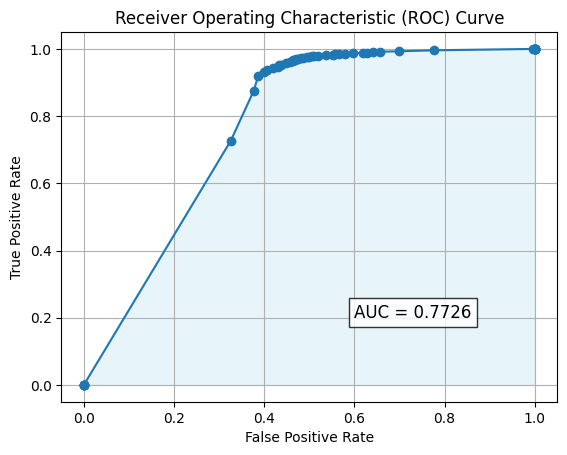

Epoch 15
--------------TRAIN-----------------
Current file/Number of files: [   30/ 4620]
loss VAD: 0.321381
Loss L: 0.016678238287568092
Accuracy of batch: 89.654217
Learning rate: 0.000068
Current file/Number of files: [   60/ 4620]
loss VAD: 0.323813
Loss L: 0.016678206622600555
Accuracy of batch: 89.363624
Learning rate: 0.000068
Current file/Number of files: [   90/ 4620]
loss VAD: 0.380228
Loss L: 0.01667754352092743
Accuracy of batch: 87.162915
Learning rate: 0.000068
Current file/Number of files: [  120/ 4620]
loss VAD: 0.279481
Loss L: 0.01667720265686512
Accuracy of batch: 91.359493
Learning rate: 0.000068
Current file/Number of files: [  150/ 4620]
loss VAD: 0.356498
Loss L: 0.01667787693440914
Accuracy of batch: 87.807912
Learning rate: 0.000068
Current file/Number of files: [  180/ 4620]
loss VAD: 0.349314
Loss L: 0.016677532345056534
Accuracy of batch: 88.453171
Learning rate: 0.000068
Current file/Number of files: [  210/ 4620]
loss VAD: 0.319983
Loss L: 0.01667704060673

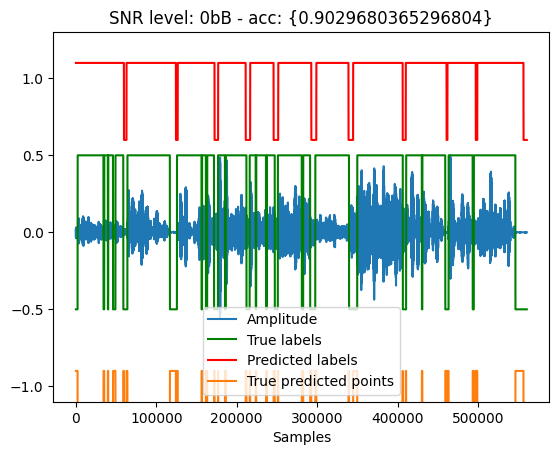

Time to execute model: 2.255678176879883


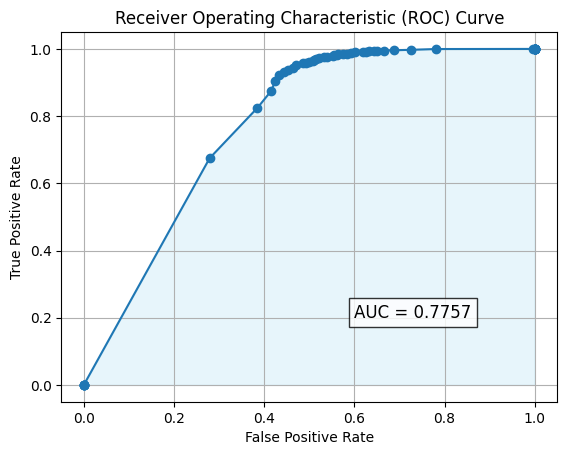

Accuracy : 0.9270797672030127
Make plot


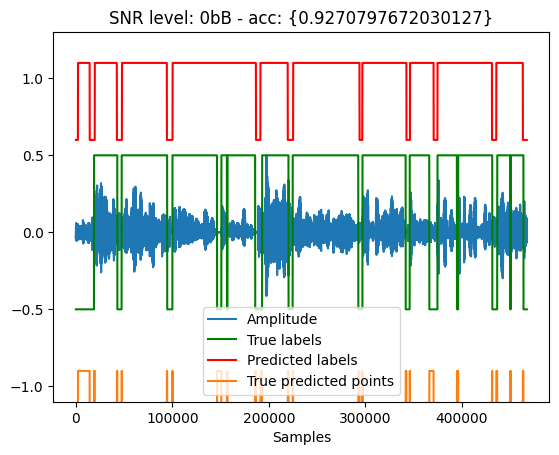

Time to execute model: 2.4271011352539062


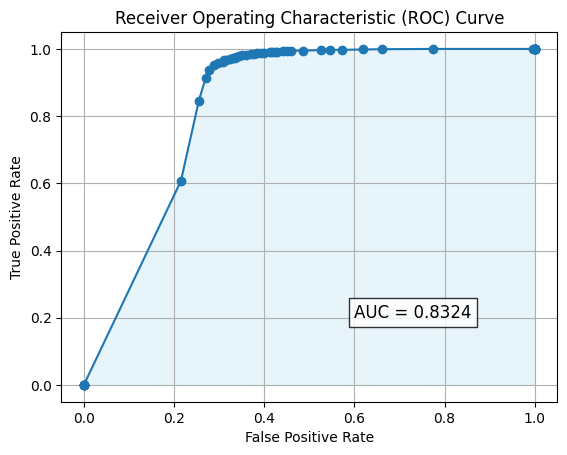

Accuracy : 0.9231984829329962
Make plot


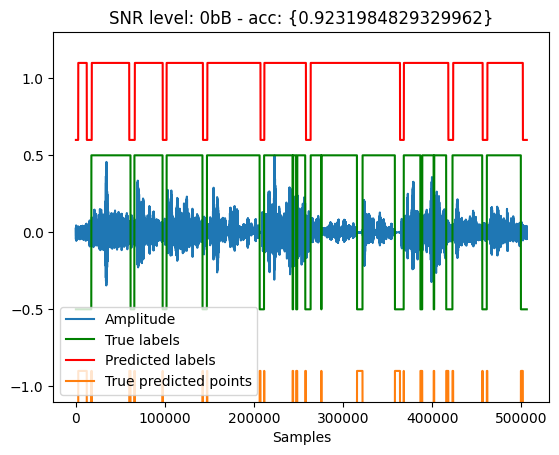

Time to execute model: 2.076864242553711


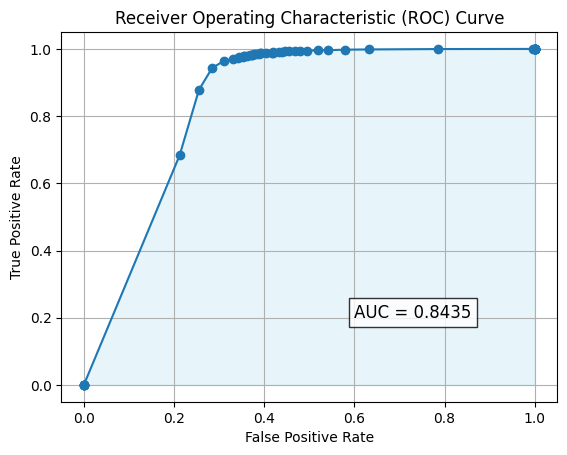

Epoch 16
--------------TRAIN-----------------
Current file/Number of files: [   30/ 4620]
loss VAD: 0.341142
Loss L: 0.016626520082354546
Accuracy of batch: 88.661271
Learning rate: 0.000047
Current file/Number of files: [   60/ 4620]
loss VAD: 0.370208
Loss L: 0.016626279801130295
Accuracy of batch: 87.538314
Learning rate: 0.000047
Current file/Number of files: [   90/ 4620]
loss VAD: 0.322625
Loss L: 0.01662559248507023
Accuracy of batch: 89.637309
Learning rate: 0.000047
Current file/Number of files: [  120/ 4620]
loss VAD: 0.366296
Loss L: 0.016625167801976204
Accuracy of batch: 87.684080
Learning rate: 0.000047
Current file/Number of files: [  150/ 4620]
loss VAD: 0.346735
Loss L: 0.016624698415398598
Accuracy of batch: 88.465084
Learning rate: 0.000047
Current file/Number of files: [  180/ 4620]
loss VAD: 0.337735
Loss L: 0.016624538227915764
Accuracy of batch: 88.872952
Learning rate: 0.000047
Current file/Number of files: [  210/ 4620]
loss VAD: 0.339920
Loss L: 0.016624221578

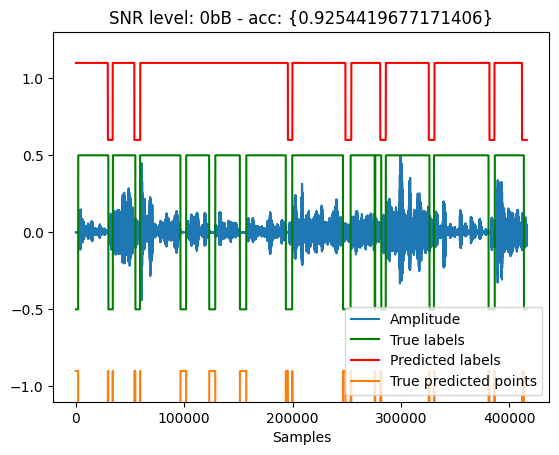

Time to execute model: 2.2759437561035156


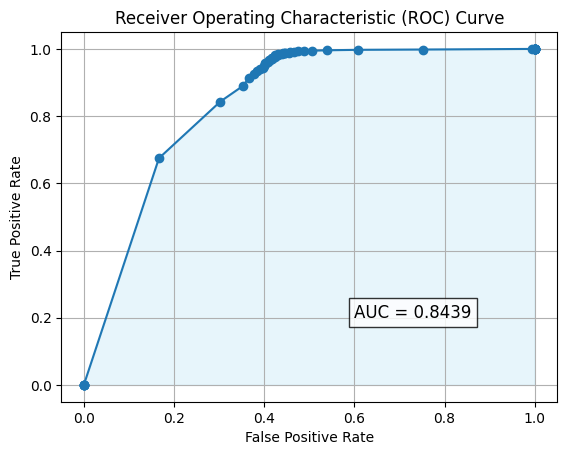

Accuracy : 0.8980628771038425
Make plot


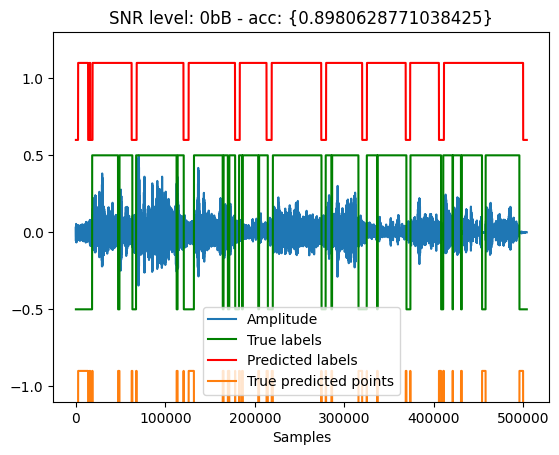

Time to execute model: 3.022432327270508


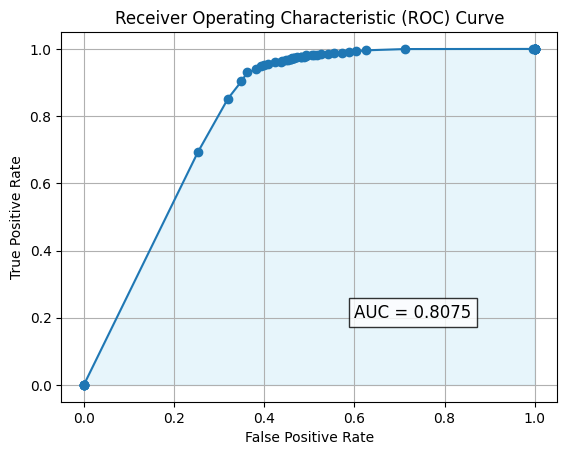

Accuracy : 0.9088008508375433
Make plot


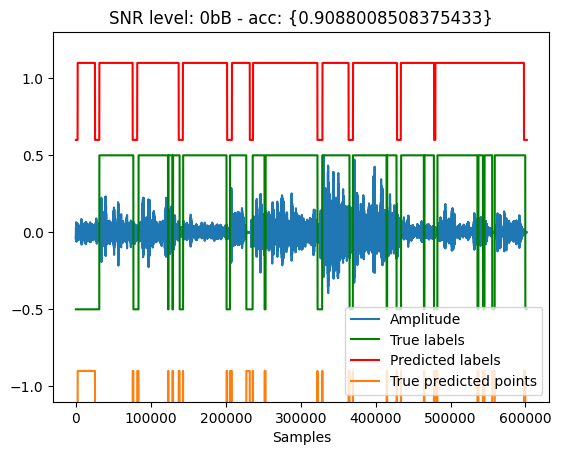

Time to execute model: 2.296924591064453


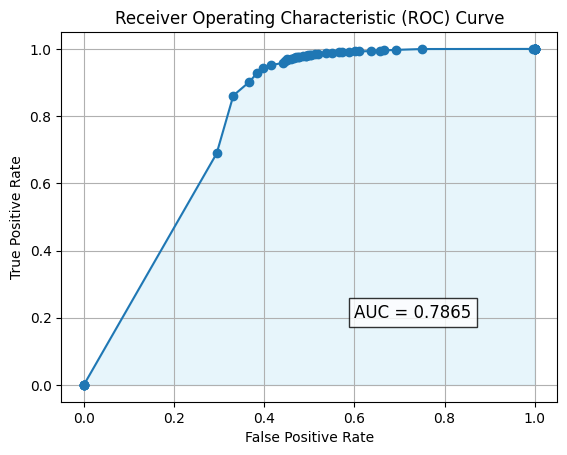

Epoch 17
--------------TRAIN-----------------
Current file/Number of files: [   30/ 4620]
loss VAD: 0.357685
Loss L: 0.016594070941209793
Accuracy of batch: 87.775472
Learning rate: 0.000033
Current file/Number of files: [   60/ 4620]
loss VAD: 0.298310
Loss L: 0.016593946143984795
Accuracy of batch: 90.337303
Learning rate: 0.000033
Current file/Number of files: [   90/ 4620]
loss VAD: 0.372571
Loss L: 0.01659385673701763
Accuracy of batch: 87.389782
Learning rate: 0.000033
Current file/Number of files: [  120/ 4620]
loss VAD: 0.342531
Loss L: 0.01659376174211502
Accuracy of batch: 88.704808
Learning rate: 0.000033
Current file/Number of files: [  150/ 4620]
loss VAD: 0.365012
Loss L: 0.016593407839536667
Accuracy of batch: 87.318597
Learning rate: 0.000033
Current file/Number of files: [  180/ 4620]
loss VAD: 0.271617
Loss L: 0.016593225300312042
Accuracy of batch: 91.837980
Learning rate: 0.000033
Current file/Number of files: [  210/ 4620]
loss VAD: 0.313556
Loss L: 0.0165933687239

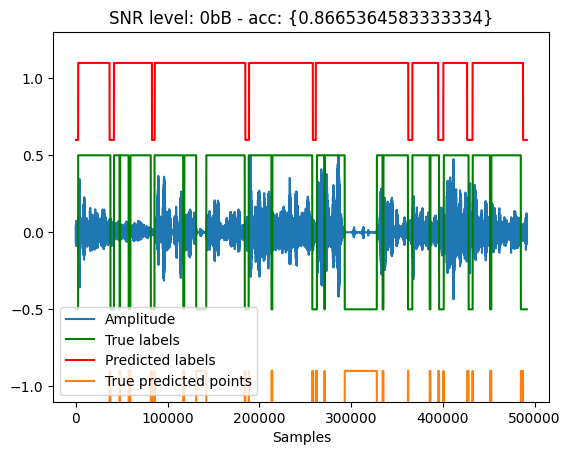

Time to execute model: 1.8401145935058594


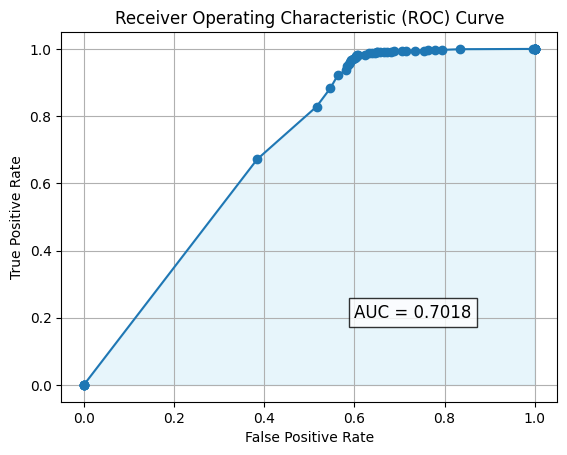

Accuracy : 0.8510765550239234
Make plot


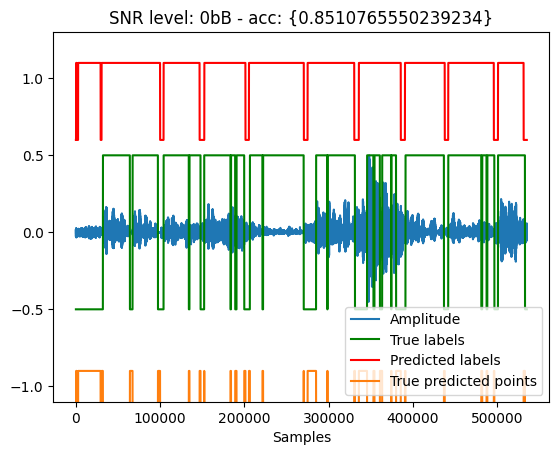

Time to execute model: 2.371072769165039


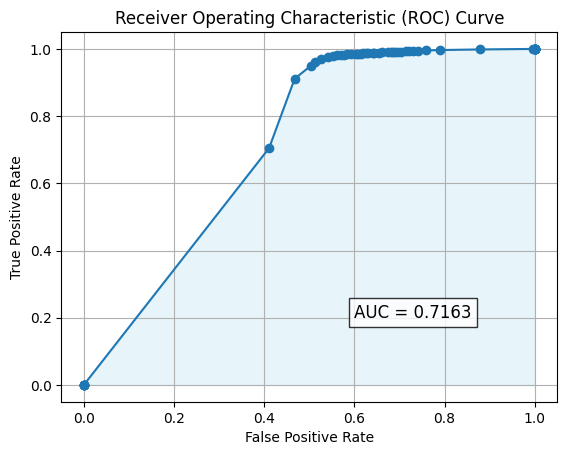

Accuracy : 0.8813314037626628
Make plot


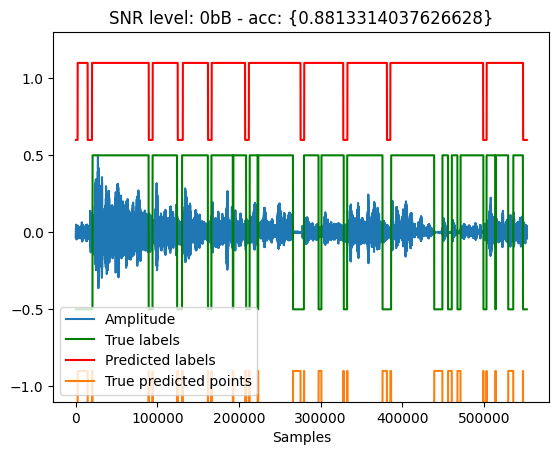

Time to execute model: 2.424001693725586


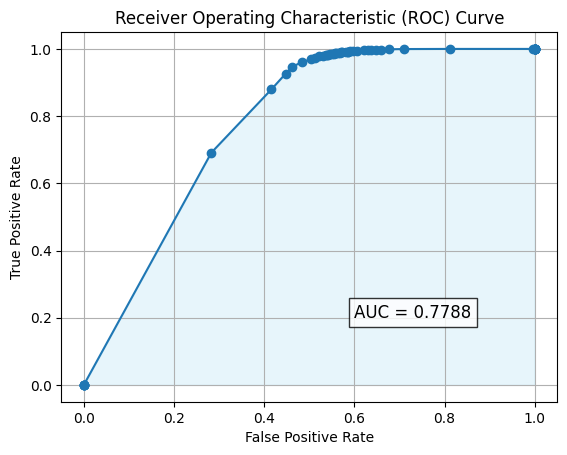

Epoch 18
--------------TRAIN-----------------
Current file/Number of files: [   30/ 4620]
loss VAD: 0.353143
Loss L: 0.01657148264348507
Accuracy of batch: 88.304234
Learning rate: 0.000023
Current file/Number of files: [   60/ 4620]
loss VAD: 0.365349
Loss L: 0.01657140627503395
Accuracy of batch: 87.720280
Learning rate: 0.000023
Current file/Number of files: [   90/ 4620]
loss VAD: 0.330443
Loss L: 0.01657142862677574
Accuracy of batch: 89.106190
Learning rate: 0.000023
Current file/Number of files: [  120/ 4620]
loss VAD: 0.361377
Loss L: 0.01657135970890522
Accuracy of batch: 87.692622
Learning rate: 0.000023
Current file/Number of files: [  150/ 4620]
loss VAD: 0.311694
Loss L: 0.01657130755484104
Accuracy of batch: 90.035392
Learning rate: 0.000023
Current file/Number of files: [  180/ 4620]
loss VAD: 0.318555
Loss L: 0.01657126657664776
Accuracy of batch: 89.667740
Learning rate: 0.000023
Current file/Number of files: [  210/ 4620]
loss VAD: 0.330587
Loss L: 0.01657133176922798

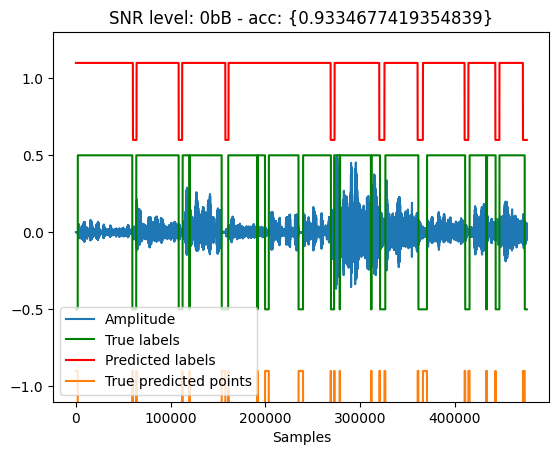

Time to execute model: 1.9333362579345703


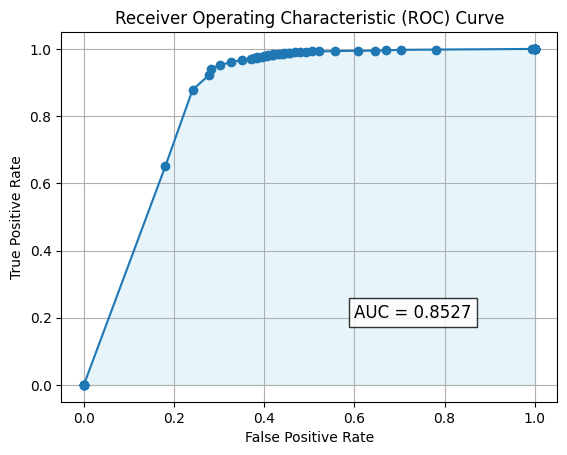

Accuracy : 0.8979354463506833
Make plot


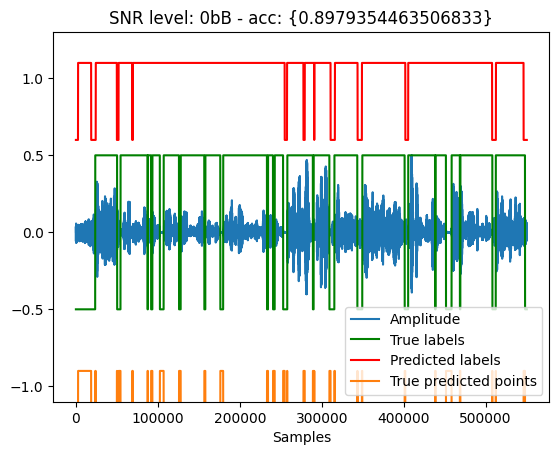

Time to execute model: 3.0319690704345703


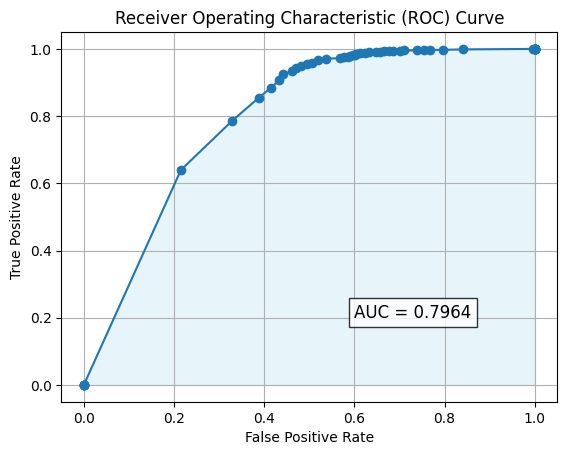

Accuracy : 0.8720136518771331
Make plot


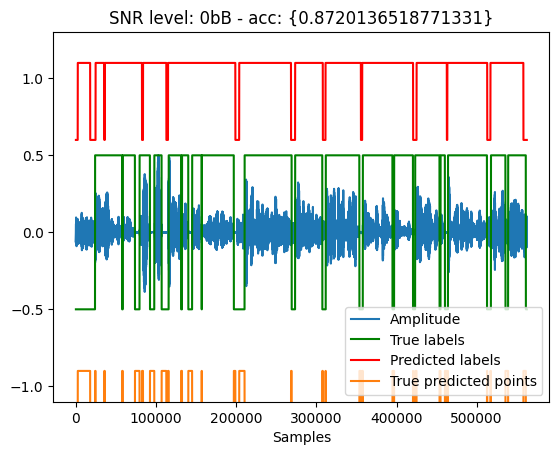

Time to execute model: 2.2258758544921875


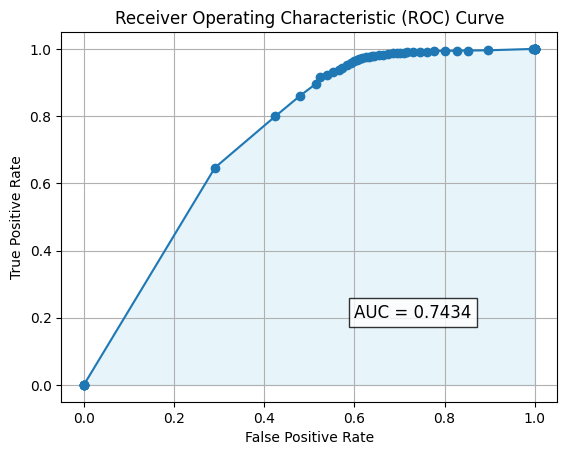

Epoch 19
--------------TRAIN-----------------
Current file/Number of files: [   30/ 4620]
loss VAD: 0.319072
Loss L: 0.016558008268475533
Accuracy of batch: 89.670368
Learning rate: 0.000016
Current file/Number of files: [   60/ 4620]
loss VAD: 0.364480
Loss L: 0.016557931900024414
Accuracy of batch: 87.514394
Learning rate: 0.000016
Current file/Number of files: [   90/ 4620]
loss VAD: 0.382418
Loss L: 0.016557754948735237
Accuracy of batch: 86.717926
Learning rate: 0.000016
Current file/Number of files: [  120/ 4620]
loss VAD: 0.387964
Loss L: 0.016557568684220314
Accuracy of batch: 86.478316
Learning rate: 0.000016
Current file/Number of files: [  150/ 4620]
loss VAD: 0.451930
Loss L: 0.01655738241970539
Accuracy of batch: 83.610032
Learning rate: 0.000016
Current file/Number of files: [  180/ 4620]
loss VAD: 0.324008
Loss L: 0.016557076945900917
Accuracy of batch: 89.527752
Learning rate: 0.000016
Current file/Number of files: [  210/ 4620]
loss VAD: 0.336917
Loss L: 0.016557095572

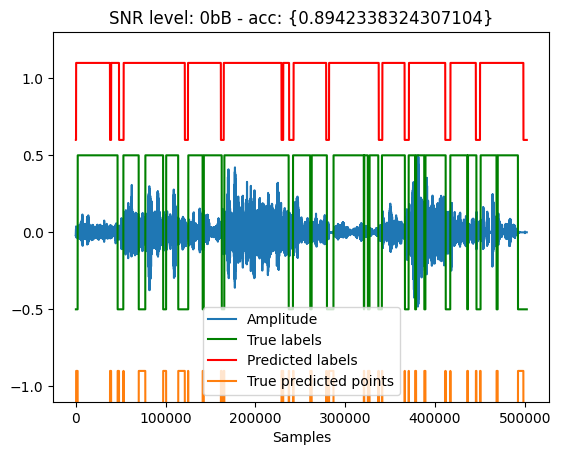

Time to execute model: 3.684520721435547


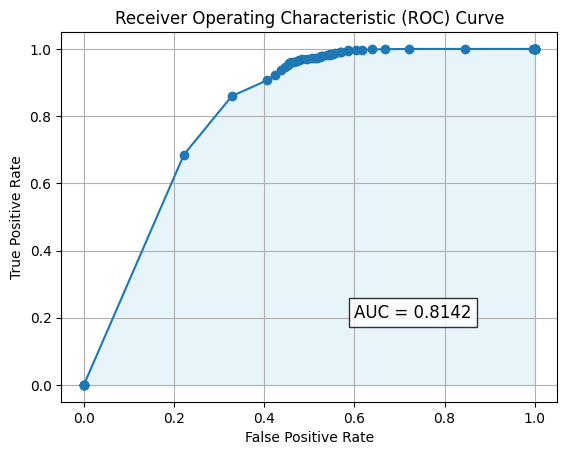

Accuracy : 0.9110512129380054
Make plot


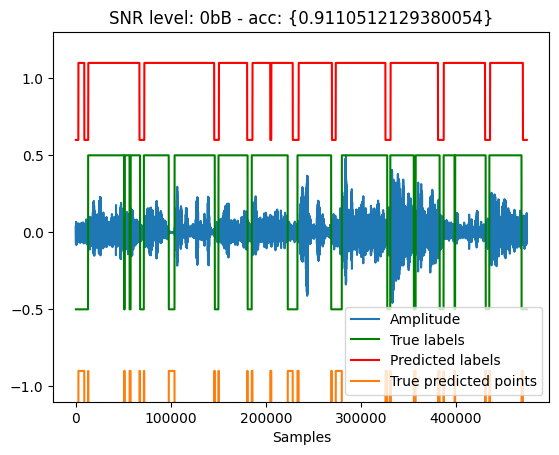

Time to execute model: 2.290010452270508


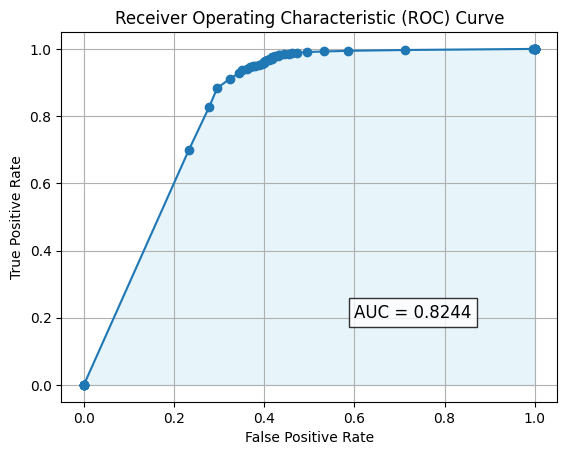

Accuracy : 0.8826512133285042
Make plot


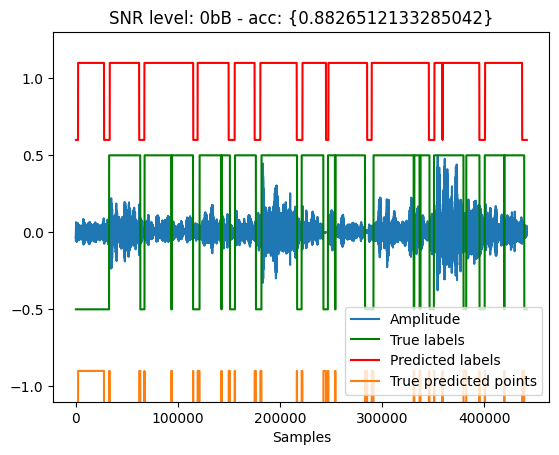

Time to execute model: 3.270864486694336


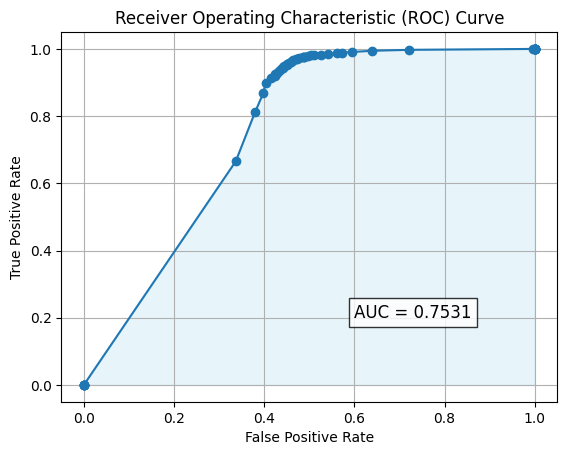

Epoch 20
--------------TRAIN-----------------
Current file/Number of files: [   30/ 4620]
loss VAD: 0.295229
Loss L: 0.016546737402677536
Accuracy of batch: 90.694319
Learning rate: 0.000011
Current file/Number of files: [   60/ 4620]
loss VAD: 0.361409
Loss L: 0.0165467020124197
Accuracy of batch: 87.460409
Learning rate: 0.000011
Current file/Number of files: [   90/ 4620]
loss VAD: 0.381469
Loss L: 0.0165465846657753
Accuracy of batch: 86.575696
Learning rate: 0.000011
Current file/Number of files: [  120/ 4620]
loss VAD: 0.353675
Loss L: 0.016546504572033882
Accuracy of batch: 88.371431
Learning rate: 0.000011
Current file/Number of files: [  150/ 4620]
loss VAD: 0.350732
Loss L: 0.016546444967389107
Accuracy of batch: 87.958050
Learning rate: 0.000011
Current file/Number of files: [  180/ 4620]
loss VAD: 0.278650
Loss L: 0.016546349972486496
Accuracy of batch: 91.564404
Learning rate: 0.000011
Current file/Number of files: [  210/ 4620]
loss VAD: 0.386457
Loss L: 0.016546349972486

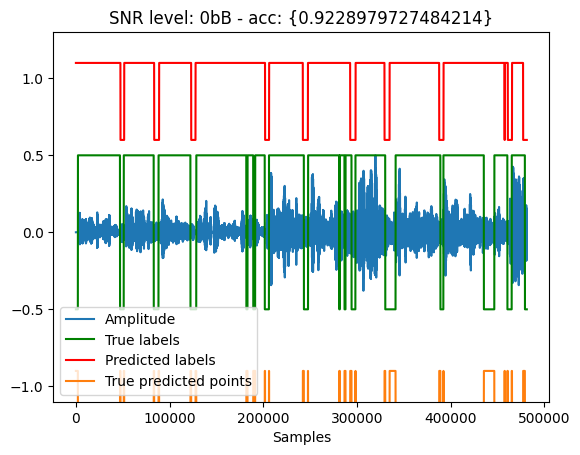

Time to execute model: 2.037525177001953


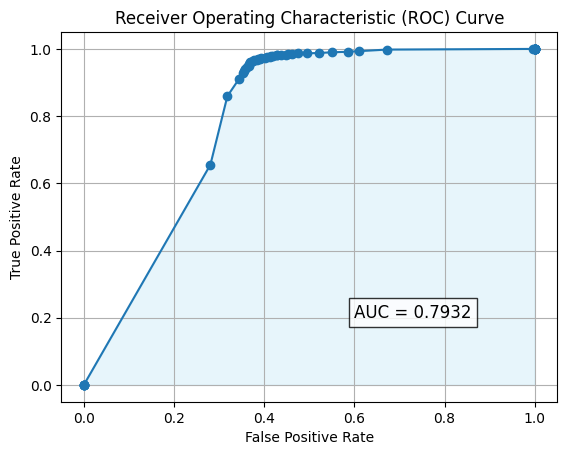

Accuracy : 0.863483523873571
Make plot


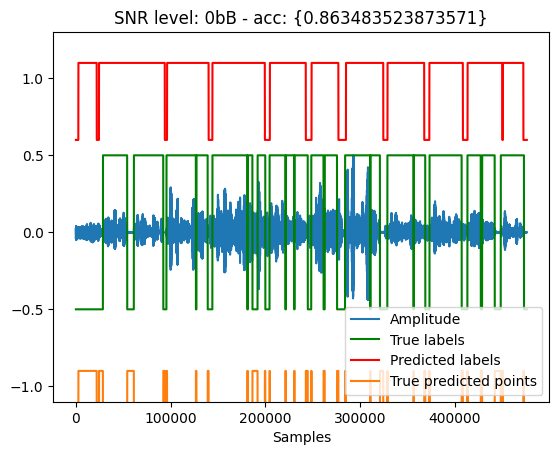

Time to execute model: 2.9981136322021484


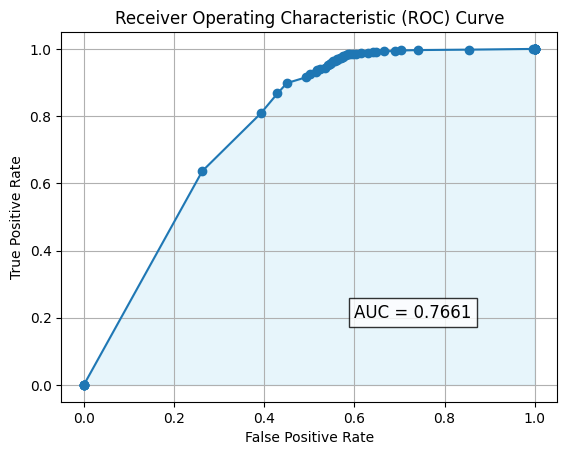

Accuracy : 0.898124191461837
Make plot


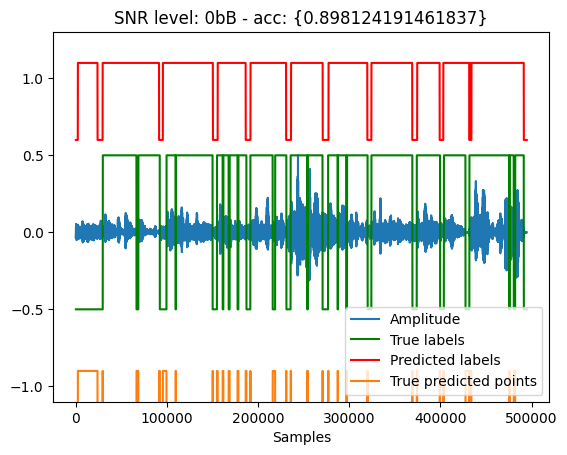

Time to execute model: 2.0530223846435547


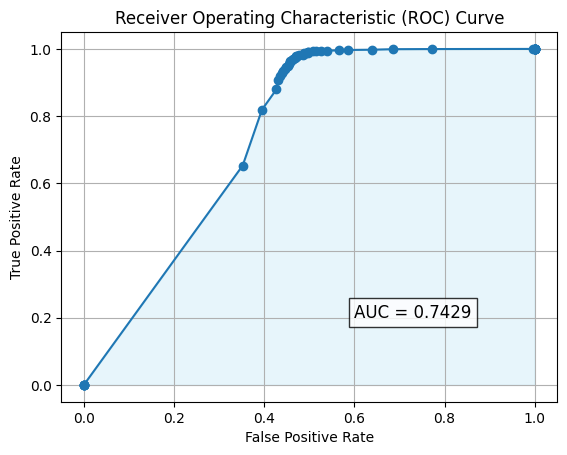

In [ ]:
pretrained = True
continue_train = False

path_to_model = "/content/model_epoch_19.pth"

if(pretrained):
  load_model(path_to_model)
  # if(continue_train):
  #   for t in range(20, 30):
  #     run_train(t)
  #     run_test(t)
else:
  for t in range(training_epochs):
      run_train(t)
      run_test(t)